# Second Report: Financial Market Volatility

By: Abigail Alpert and Gabi Wurgaft

# Project Goal

Predict volatility for the following day for AAPL, LLY, and BEP stocks.

# Current Project Stage

Data Exploration and descriptive analytics

In [1]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import datetime

Structure:

- Data management
- Summary statistics
- Time series plots
- Returns
- Variance
- Volatility
    - Daily volatility
    - Aggregated volatility
- Correlation
- EWMA
- Outlier detection
- Next steps


# Data Management

In [ ]:
# Read Data
aapl_df = pd.read_csv("data_files/AAPL_combined.csv.gz")
lly_df = pd.read_csv("data_files/LLY_combined.csv.gz")
bep_df = pd.read_csv("data_files/BEP_combined.csv.gz")

# Data Preprocessing
def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl_df = data_preprocess(aapl_df)
lly_df = data_preprocess(lly_df)
bep_df = data_preprocess(bep_df)

FileNotFoundError: [Errno 2] No such file or directory: 'data_files/AAPL_combined.csv.gz'

# Summary Statistics

In [3]:
aapl_df.describe()

,timestamp,open,high,low,close,volume
count,562931,562931.000000,562931.000000,562931.000000,562931.000000,5.629310e+05
mean,2022-11-14 21:03:20.477216768,160.515991,160.593207,160.437746,160.516211,1.647944e+05
min,2020-01-02 09:30:00,51.539100,51.672300,51.476200,51.529400,6.000000e+00
25%,2021-06-09 11:06:30,130.567100,130.630900,130.504700,130.565450,6.793800e+04
50%,2022-11-11 10:26:00,160.717500,160.820600,160.624200,160.718600,1.116850e+05
75%,2024-04-23 10:26:30,190.944100,191.003600,190.879900,190.944100,1.919780e+05
max,2025-09-30 15:59:00,259.008600,265.706100,258.809300,259.028400,2.035834e+07
std,NaN,45.624113,45.636280,45.611705,45.624154,2.178602e+05


Notice that the stock price varies by about $200 over the full dataframe. Since our data is on a minute level, the values do not differ too much between the open, high, low, and close prices.

In [4]:
lly_df.describe()

,timestamp,open,high,low,close,volume
count,558186,558186.000000,558186.000000,558186.000000,558186.000000,5.581860e+05
mean,2022-11-13 02:29:51.056314112,433.285002,433.485025,433.081830,433.283493,5.859736e+03
min,2020-01-02 09:31:00,109.690000,109.971000,109.643100,109.821100,1.000000e+00
25%,2021-06-07 13:27:15,208.908500,208.970800,208.842600,208.890500,1.717000e+03
50%,2022-11-09 10:45:30,323.250800,323.396450,323.113400,323.259600,3.252000e+03
75%,2024-04-19 13:40:45,733.159150,733.555975,732.695800,733.151675,6.246000e+03
max,2025-09-30 15:59:00,964.839100,965.136800,963.310800,964.610700,1.246834e+06
std,NaN,264.277398,264.407444,264.144637,264.275595,1.108389e+04


Notice that the stock price varies by about $850 over the full dataframe. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [5]:
bep_df.describe()

,timestamp,open,high,low,close,volume
count,401488,401488.000000,401488.000000,401488.000000,401488.000000,401488.000000
mean,2022-11-08 15:37:05.745377024,25.741919,25.750977,25.732866,25.741928,1495.447027
min,2020-01-02 09:30:00,12.429000,12.449800,12.388100,12.429300,1.000000
25%,2021-05-03 14:49:45,22.239900,22.246400,22.230300,22.239900,261.000000
50%,2022-11-02 15:31:30,24.789400,24.795600,24.782100,24.790000,628.000000
75%,2024-05-03 14:42:15,29.526100,29.535600,29.519200,29.527400,1549.000000
max,2025-09-30 15:59:00,39.598300,39.598300,39.534800,39.550700,423712.000000
std,NaN,4.781916,4.782594,4.781305,4.781990,3329.225258


Notice that the stock prices varies by about $35 over the full dataframe. This is considerably less than the other stocks that we are looking at. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

# Time Series Plot

In [6]:
def plot_timeseries(df, column, stock):
    g = (ggplot(df) + 
         geom_line(aes(x='timestamp', y=column)) + 
         labs(title=f"{stock}: {column} price"))
    return g
def plot_timeseries_grid(df, columns, stock):
    n = len(columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        g = plot_timeseries(df, column, stock)
        g.draw(axes[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Apple Plots

Although there is a general upwards trend over time, the increase in stock price is not consistent

In [7]:
plot_timeseries(aapl_df, ['open','close'], "AAPL")

PlotnineError: 'Aesthetics must either be length one, or the same length as the data'

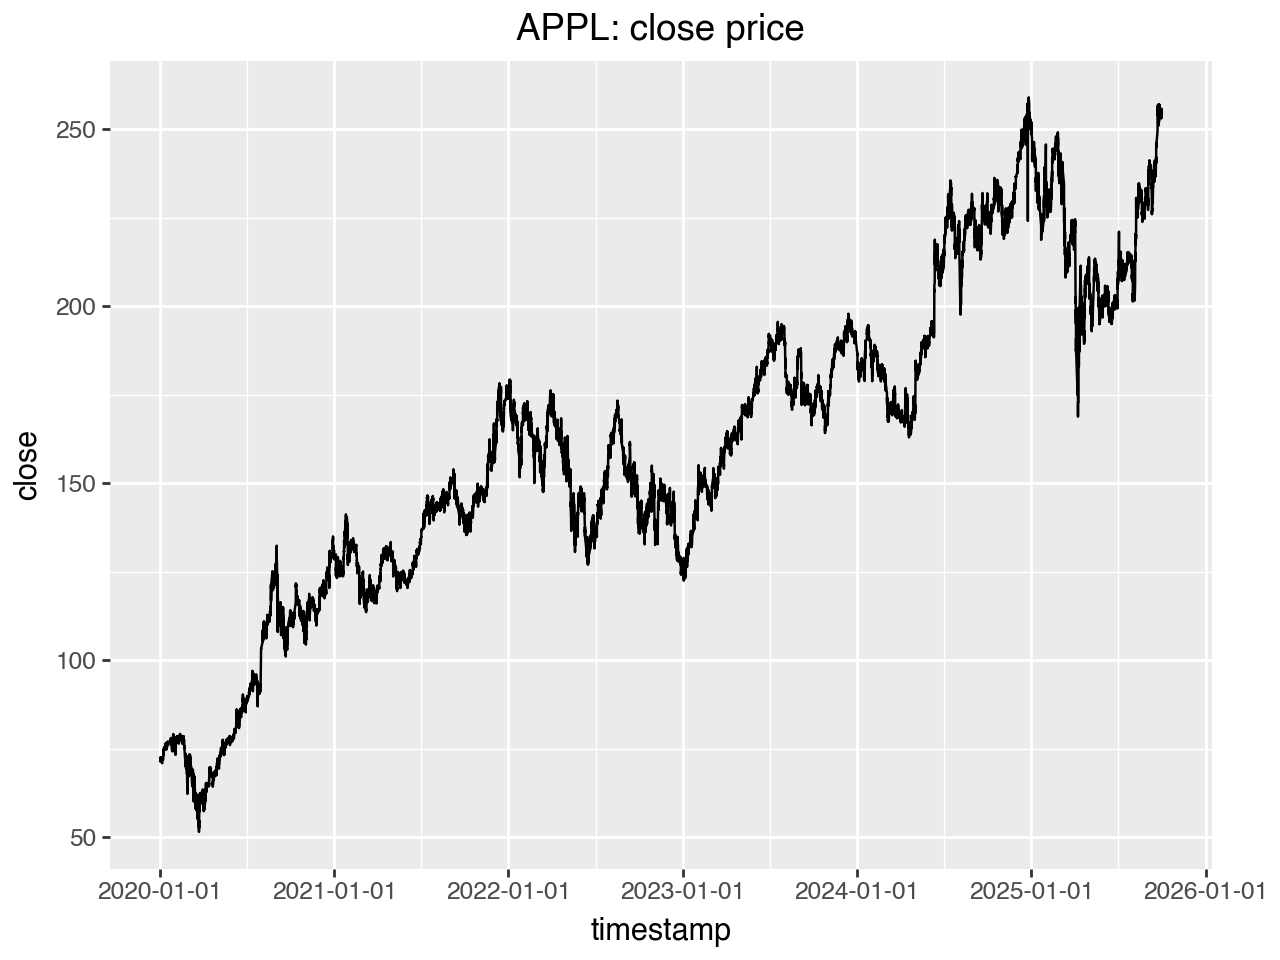

In [8]:
plot_timeseries(aapl_df, 'close', "APPL")

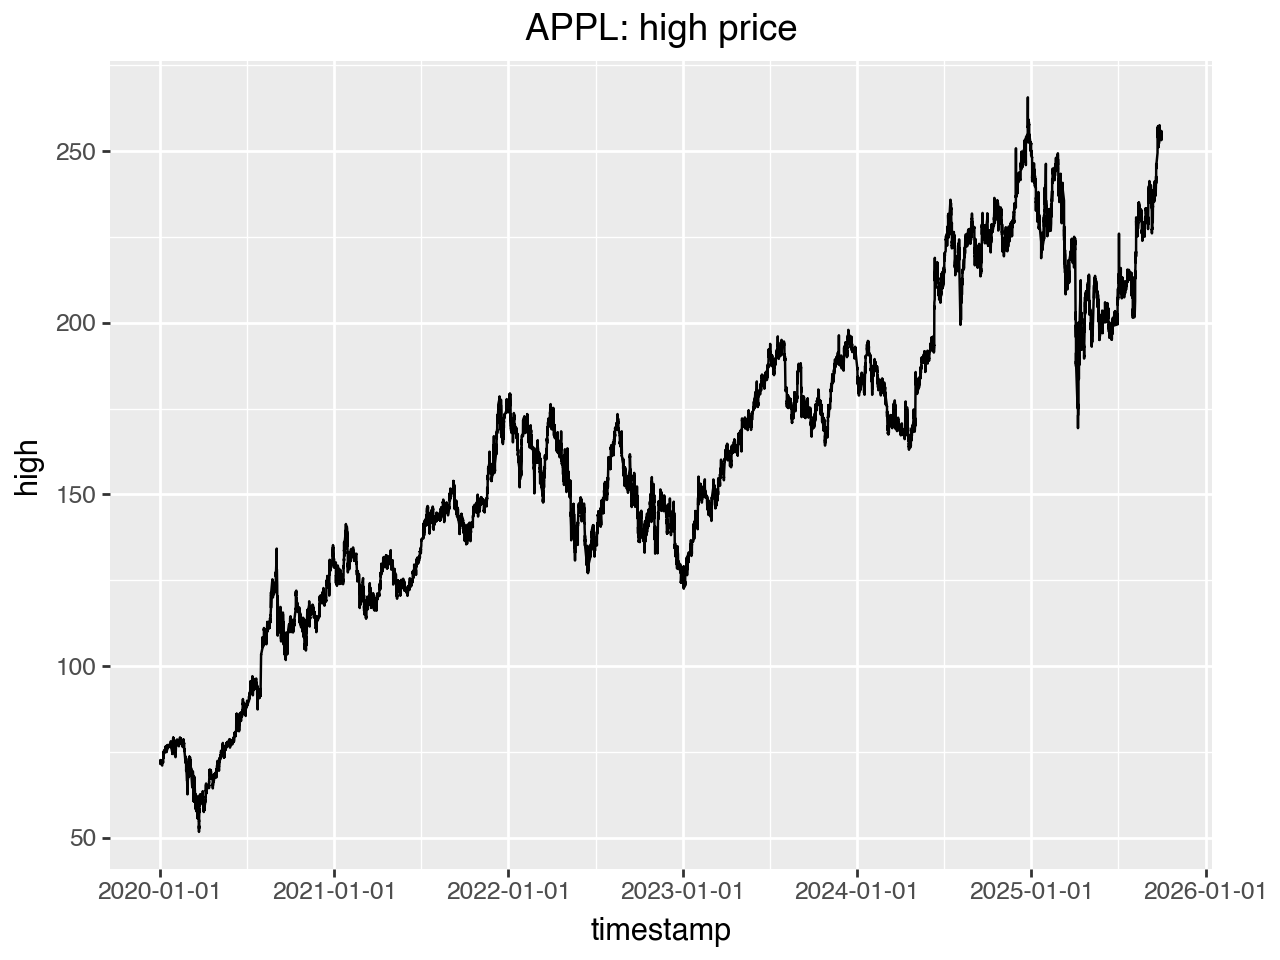

In [9]:
plot_timeseries(aapl_df, 'high', "APPL")


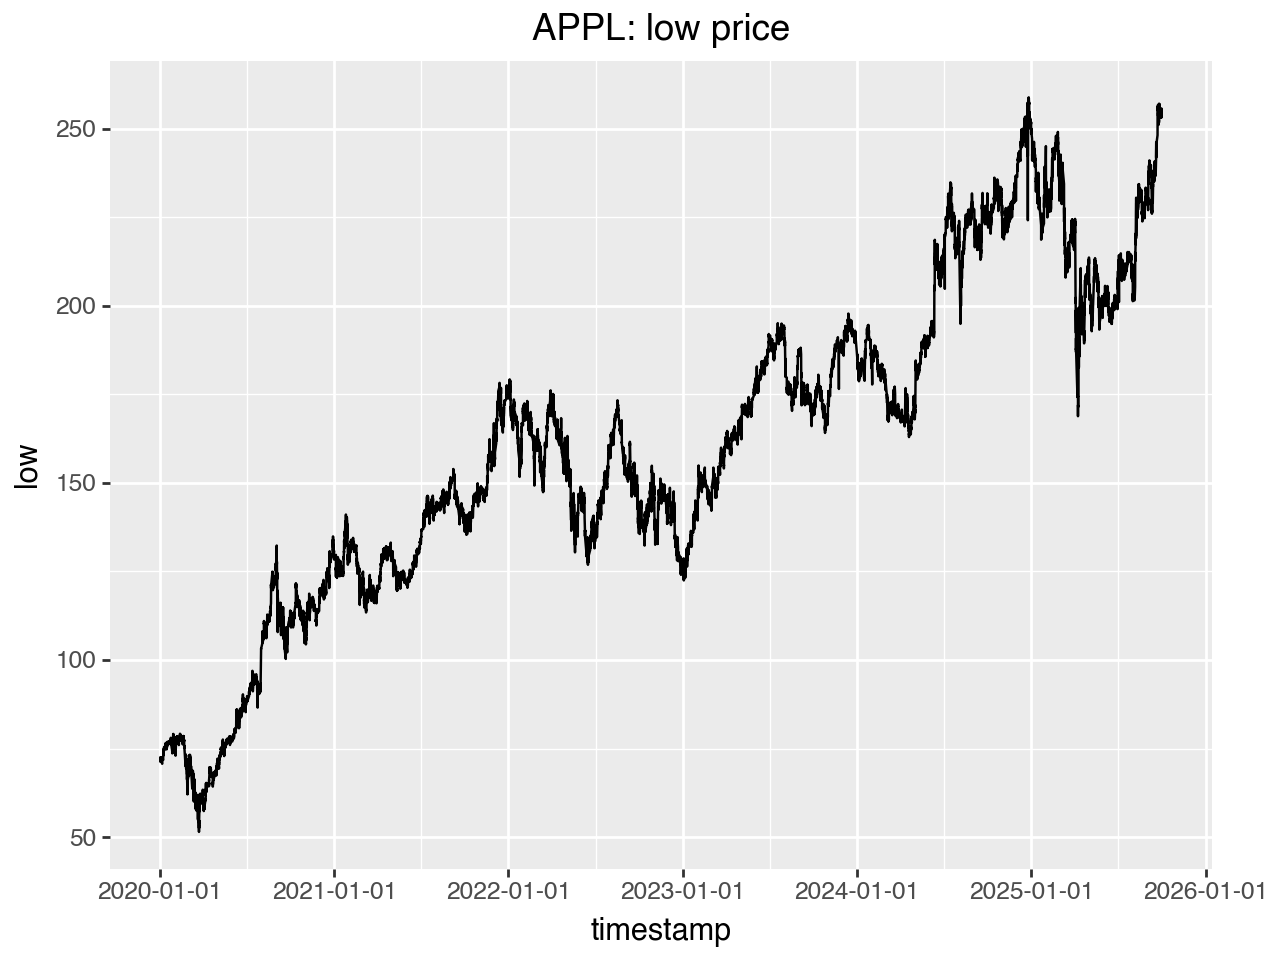

In [10]:
plot_timeseries(aapl_df, 'low', "APPL")

### Eli Lilly Plots

Notice that the stock price was increasing steadily until March 2023 when the price increased dramatically. Since June 2024, the LLY stock price has been on a general decreasing trend

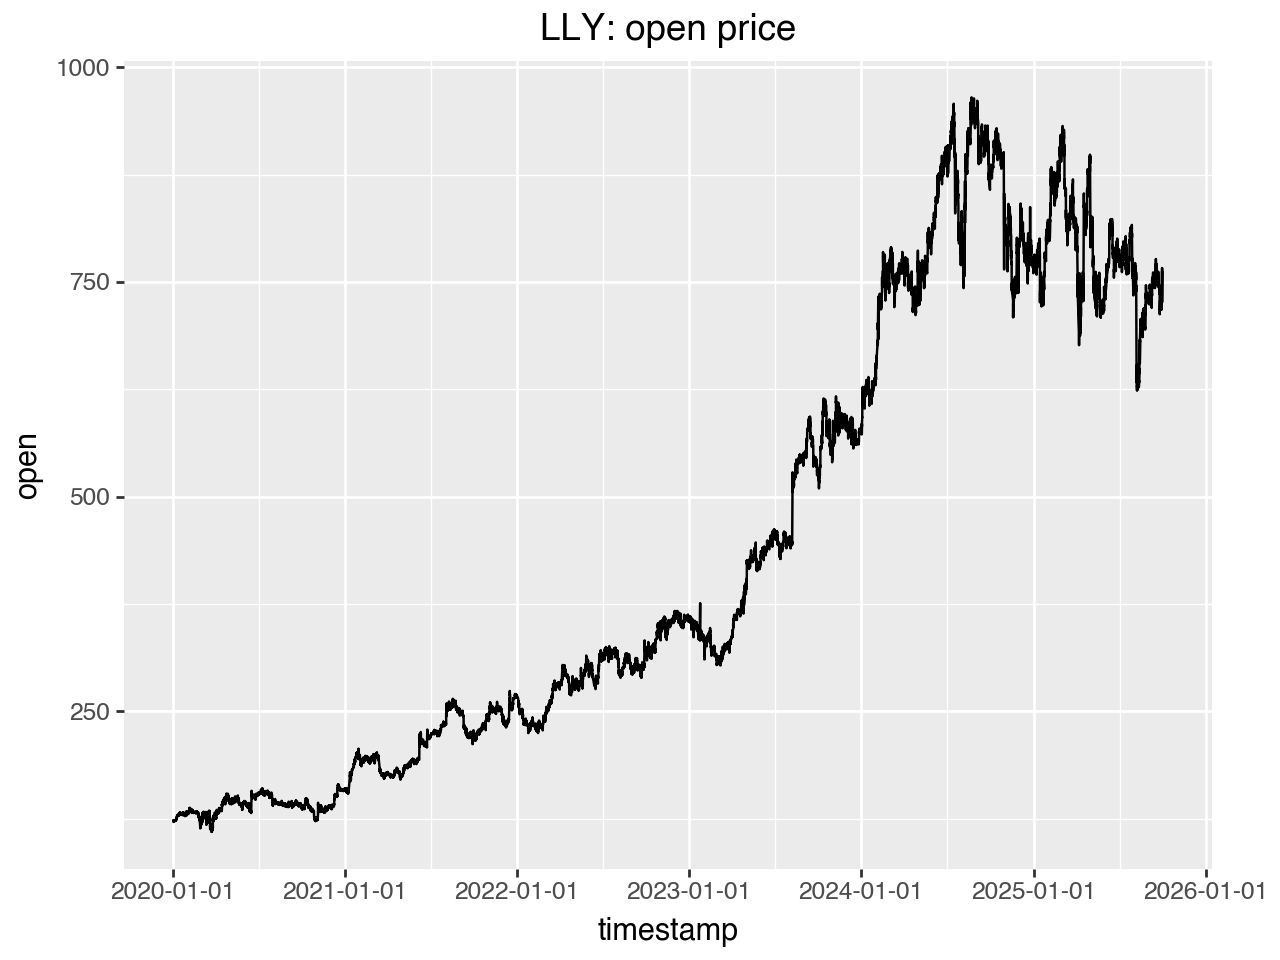

In [11]:
plot_timeseries(lly_df, 'open', 'LLY')

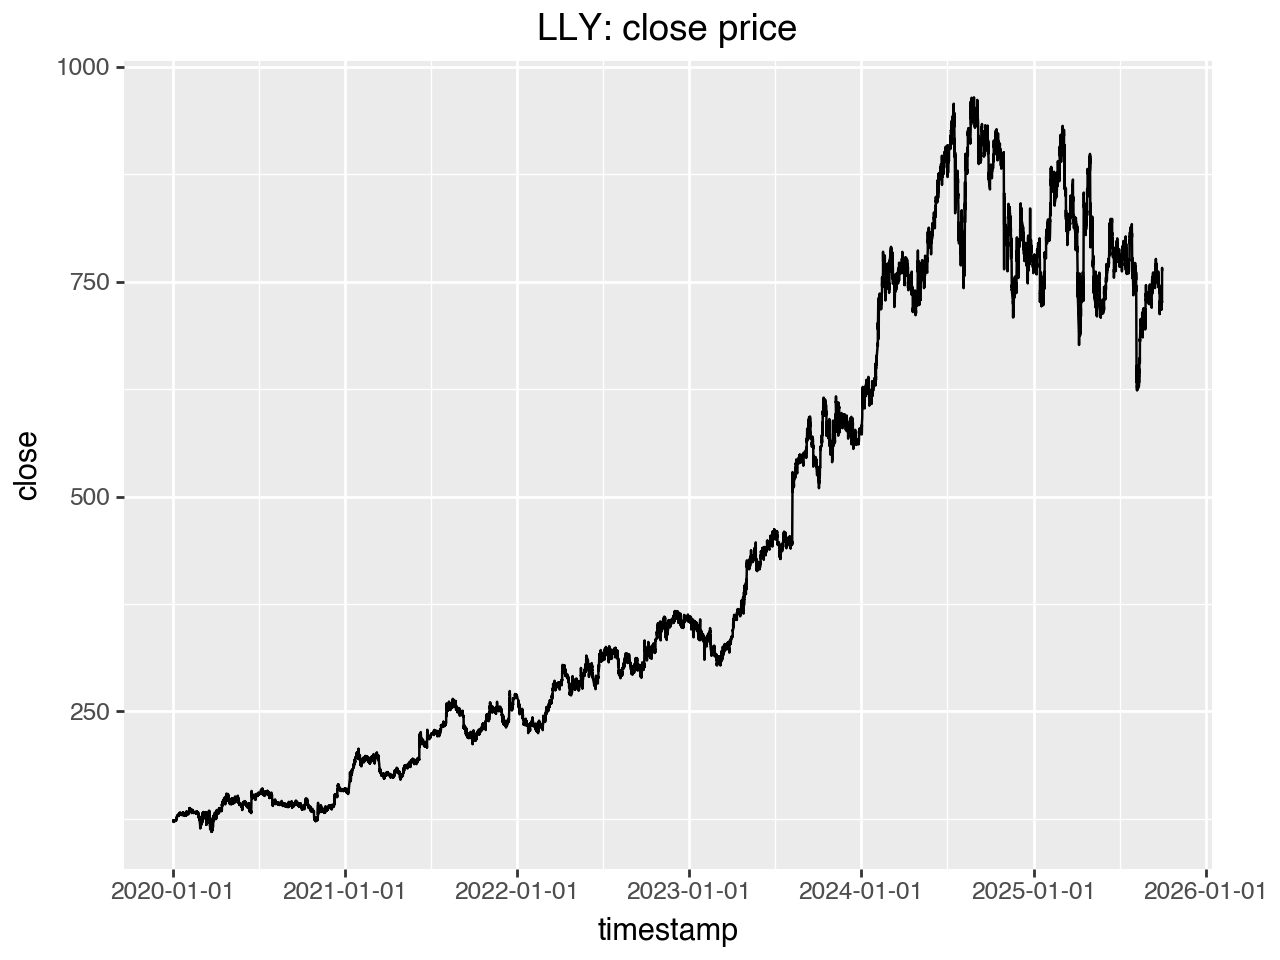

In [12]:
plot_timeseries(lly_df, 'close', 'LLY')

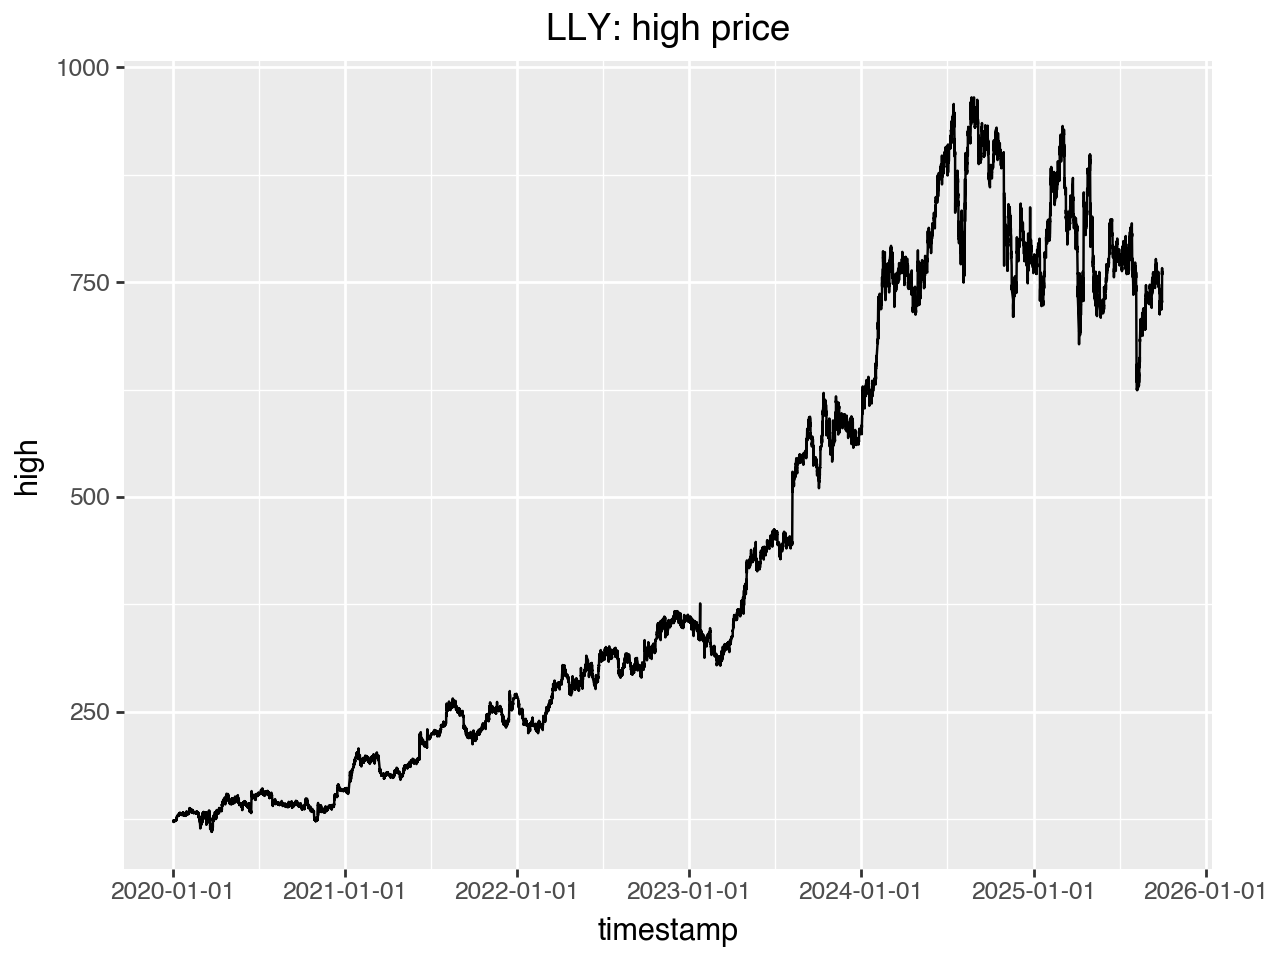

In [13]:
plot_timeseries(lly_df, 'high', 'LLY')

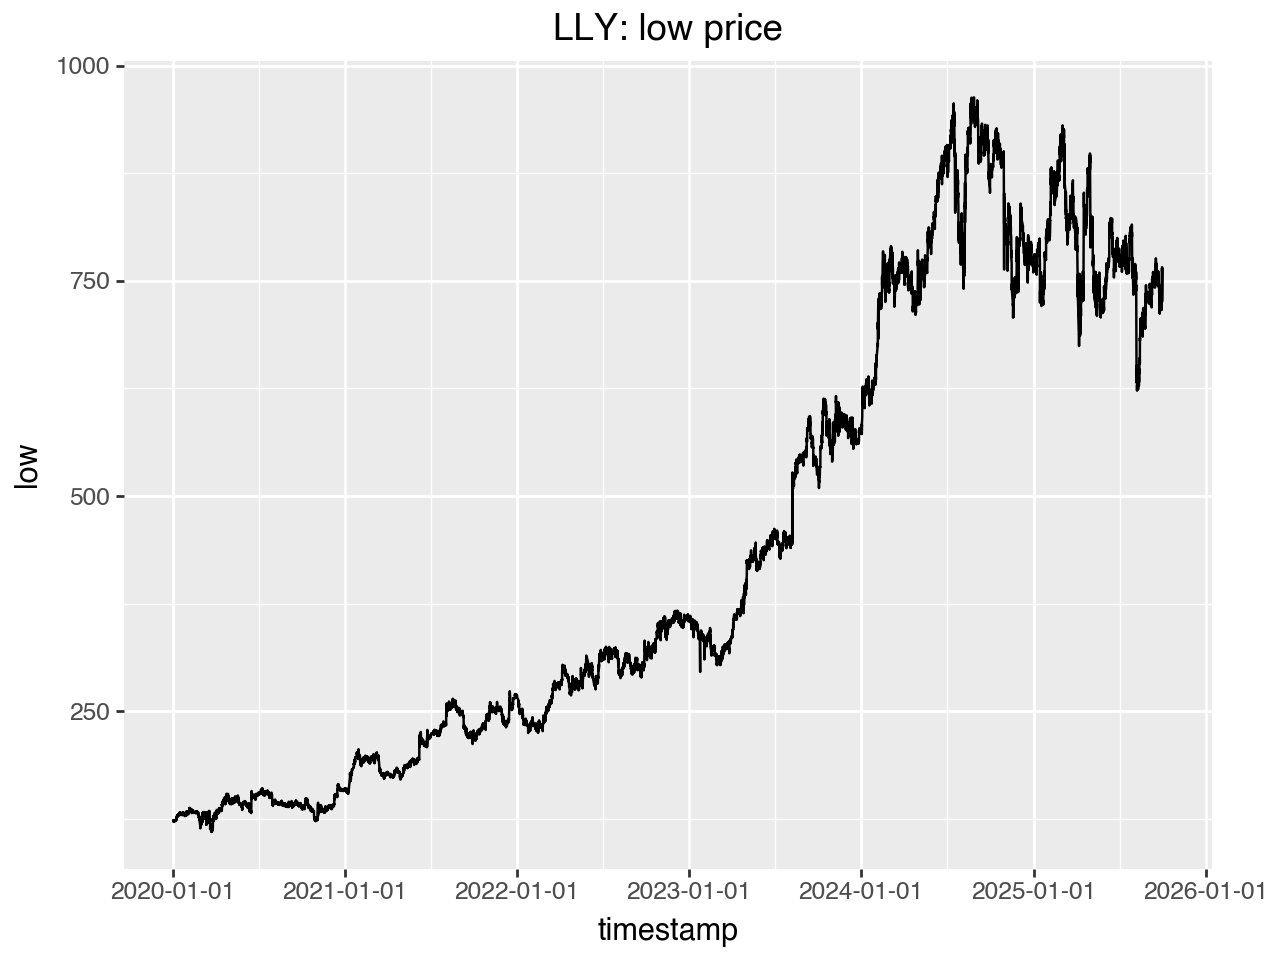

In [14]:
plot_timeseries(lly_df, 'low', 'LLY')

### Brookfield Plots

Notice that the Brookfield stock price shot up dramatically startin in March 2020 through the end of the year. Since then, there have been many flucations, but a general decrease in stock price. Since the start of 2025, the BEP stock prices has been mostly increasing.

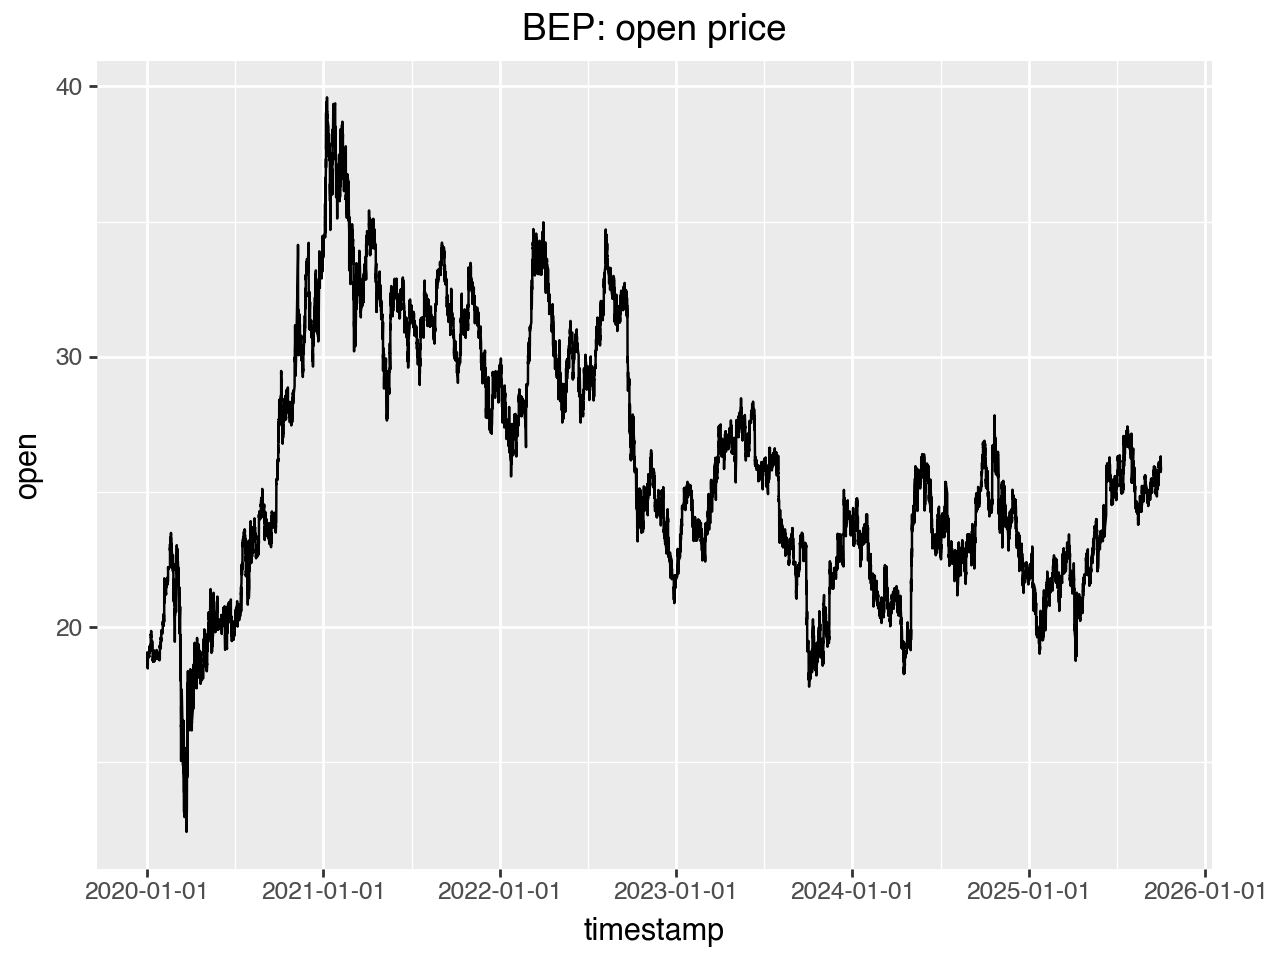

In [15]:
plot_timeseries(bep_df, 'open', 'BEP')

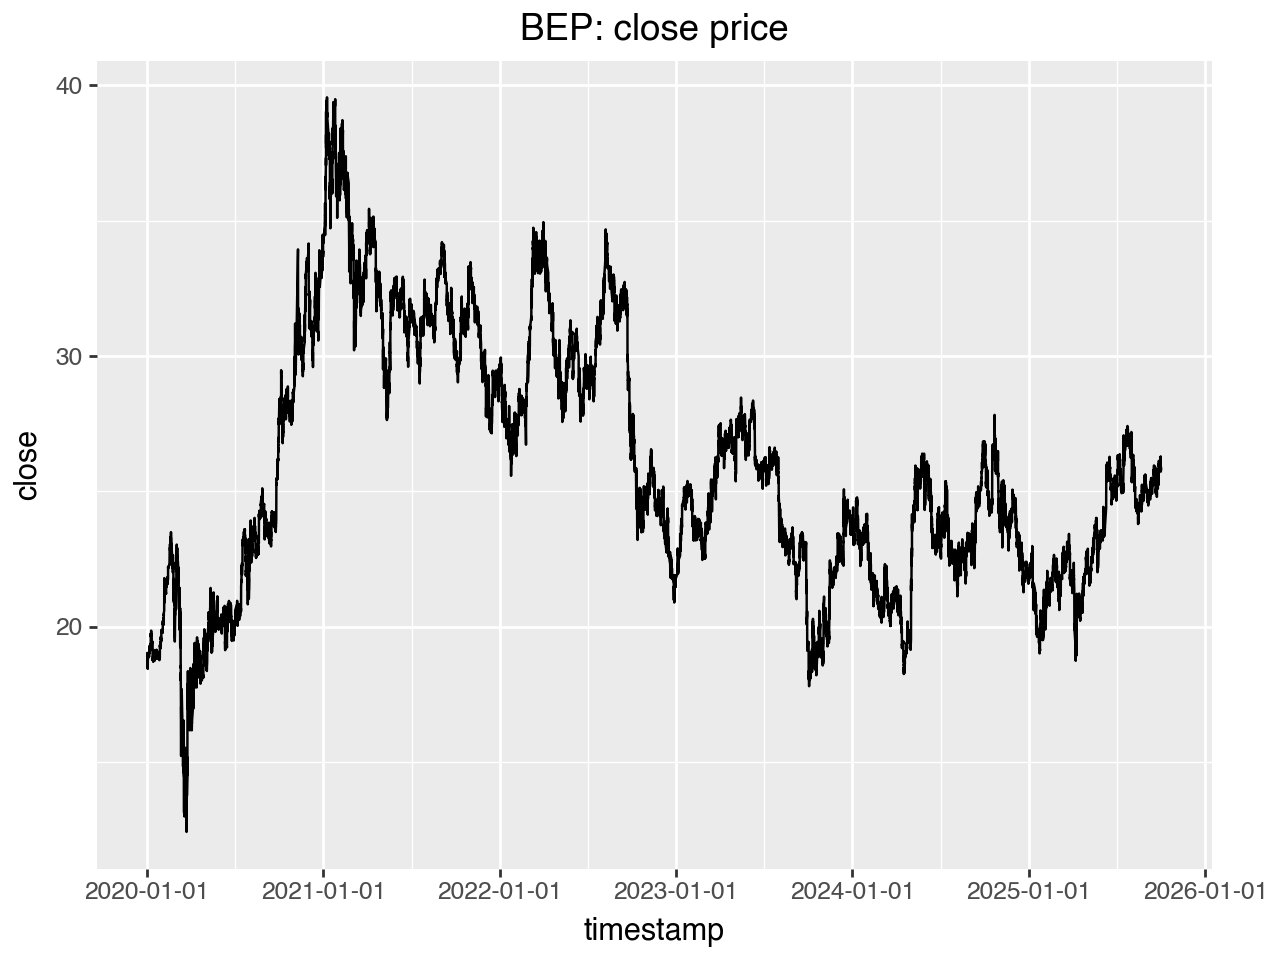

In [16]:
plot_timeseries(bep_df, 'close', 'BEP')

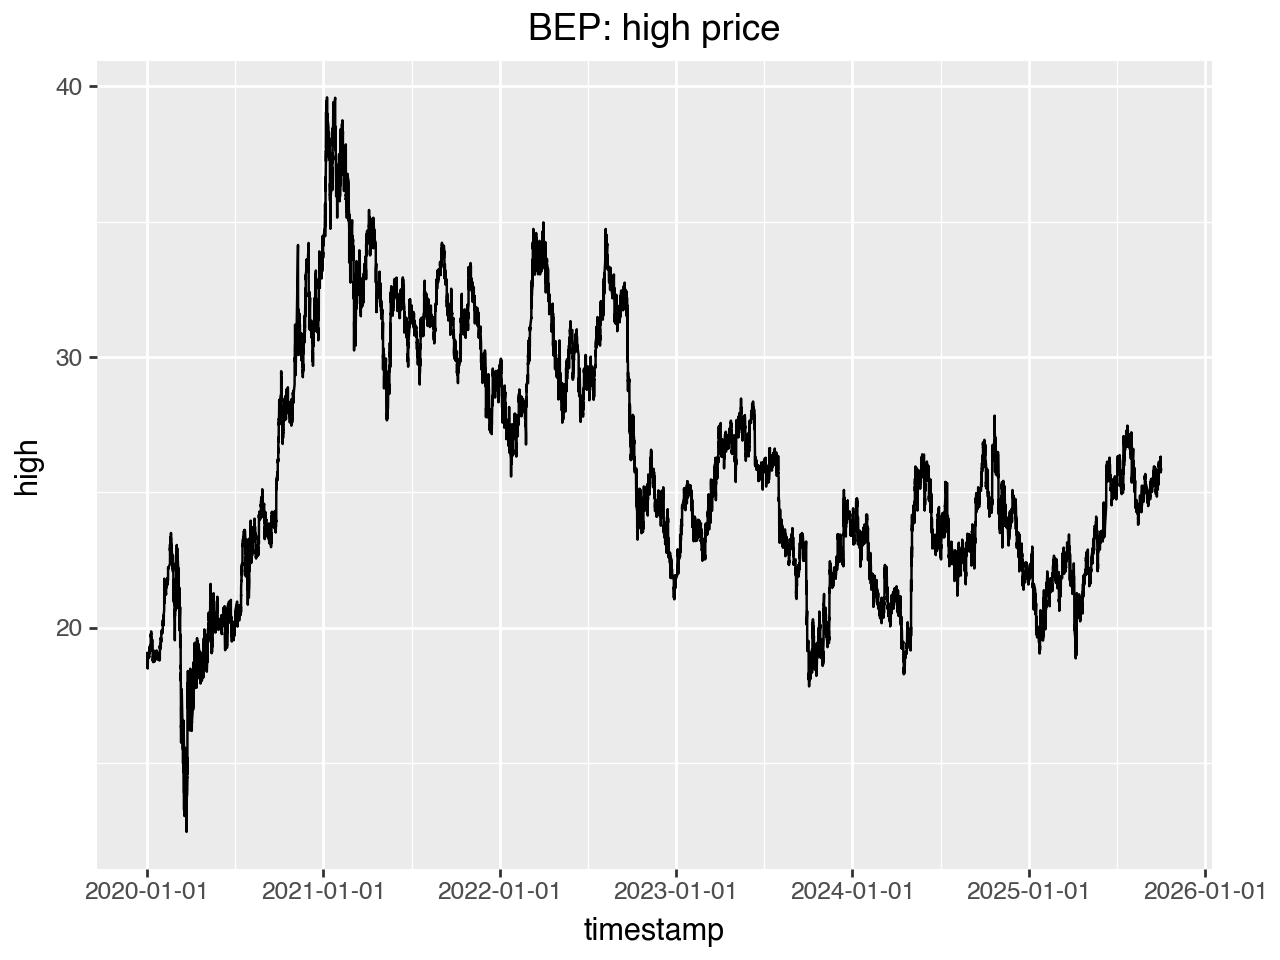

In [17]:
plot_timeseries(bep_df, 'high', 'BEP')

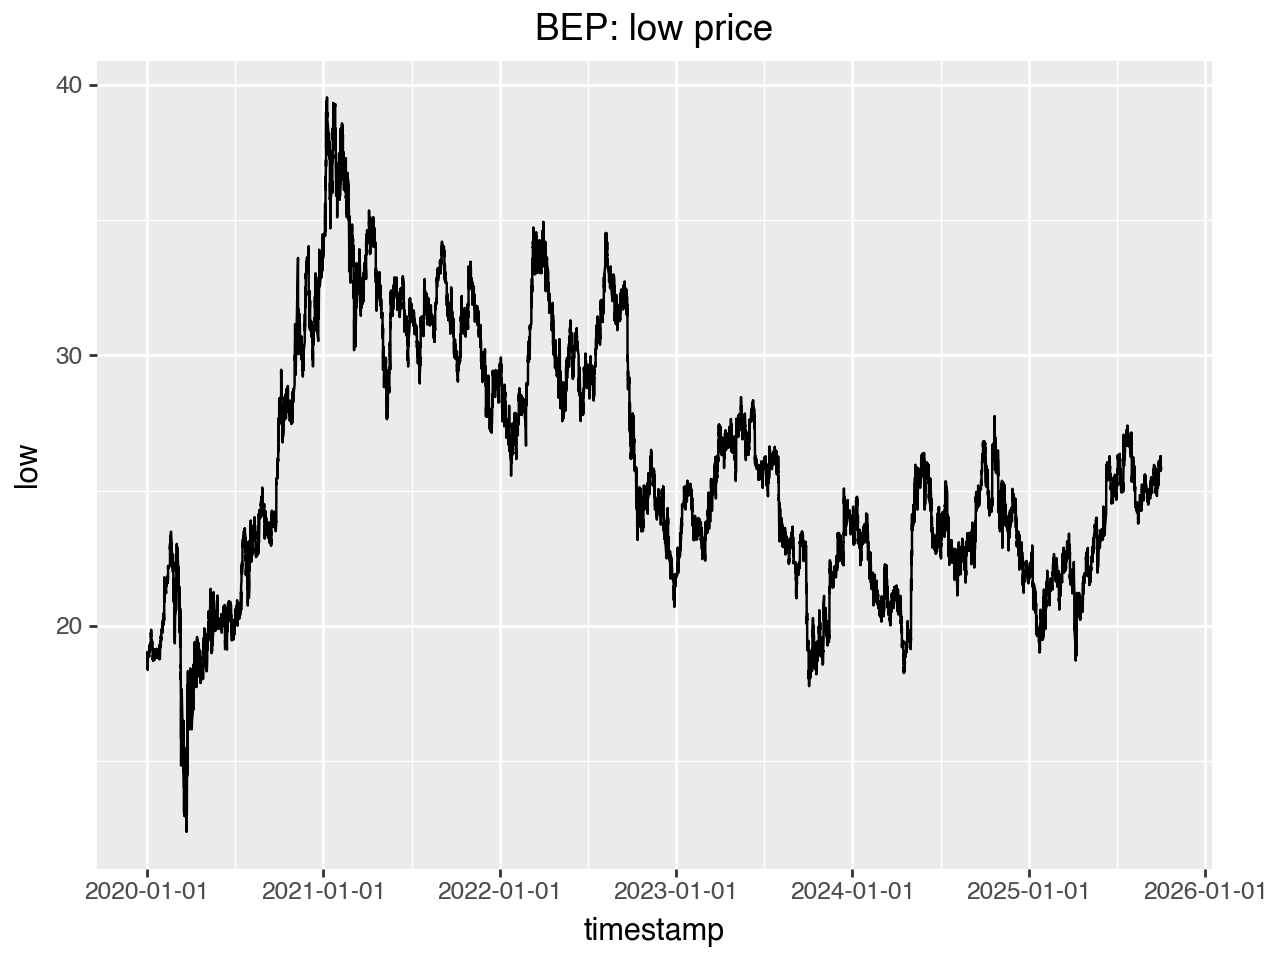

In [18]:
plot_timeseries(bep_df, 'low', 'BEP')

# Returns

In [3]:
#Load in AAPL data, make returns, variance, and volatility
AAPL_returns = pd.DataFrame({
    "time_stamp": aapl_df['timestamp'],
    "log_return": np.log(1+(aapl_df['close']-aapl_df['open'])/aapl_df['open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()


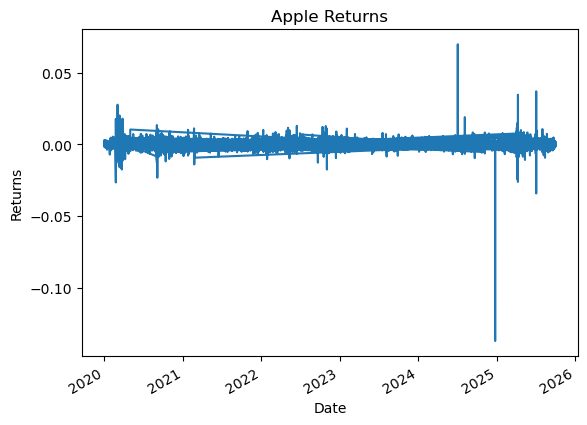

In [4]:
#Plot returns
AAPL_returns.set_index("time_stamp", inplace=True)
AAPL_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns")
plt.show()

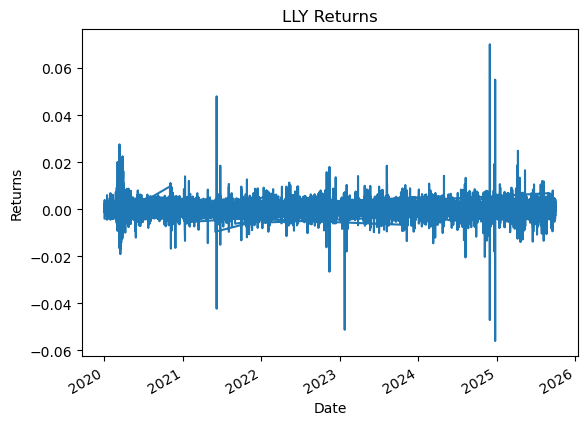

In [5]:
LLY_returns = pd.DataFrame({
    "time_stamp": lly_df["timestamp"],
    "log_return": np.log(1+(lly_df['close']-lly_df['open'])/lly_df['open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

LLY_returns.set_index("time_stamp", inplace=True)
LLY_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns")
plt.show()

In [6]:
BEP_returns = pd.DataFrame({
    "time_stamp": bep_df["timestamp"],
    "log_return": np.log(1+(bep_df['close']-bep_df['open'])/bep_df['open'])
})
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

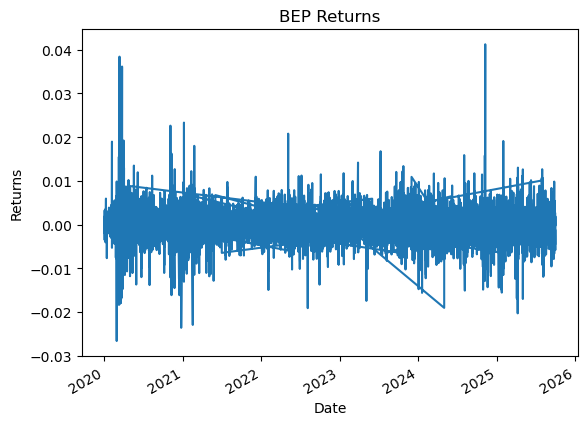

In [7]:
BEP_returns.set_index("time_stamp", inplace=True)
BEP_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("BEP Returns")
plt.show()

# Variance

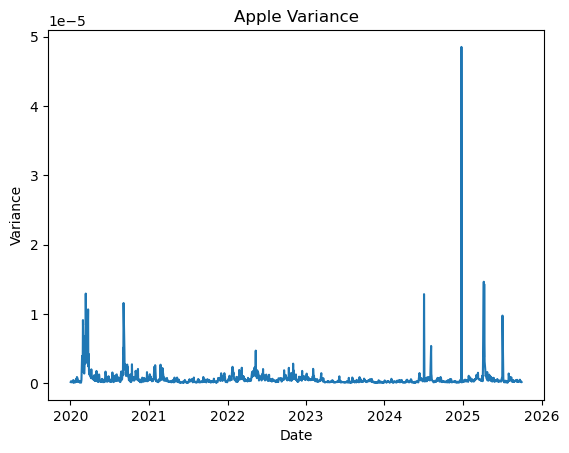

In [8]:
#Plot variance
plt.plot(daily_variance_AAPL.index, daily_variance_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")
plt.show()

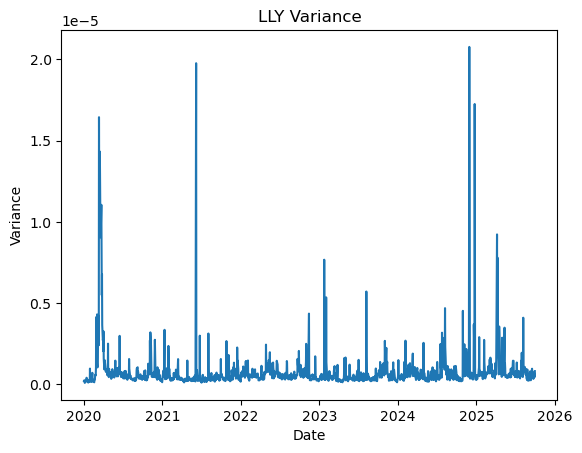

In [9]:
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")
plt.show()

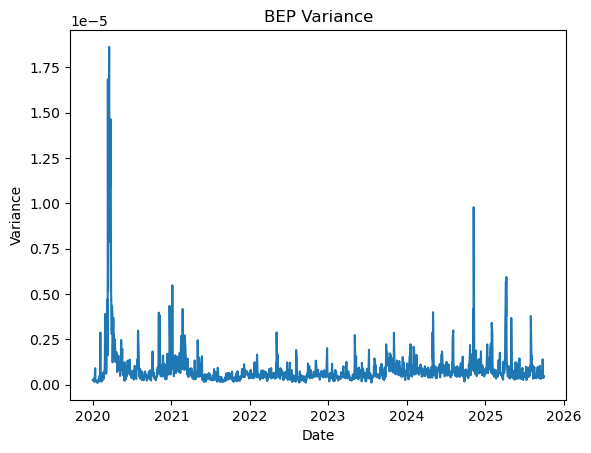

In [10]:
plt.plot(daily_variance_BEP.index, daily_variance_BEP.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance")
plt.show()

# Volatility

## Daily Volatility

Realized Volatility

In [29]:
#Plot volatility
daily_volatility_AAPL = np.sqrt(daily_variance_AAPL)
print(daily_volatility_AAPL)
df = pd.DataFrame(daily_volatility_AAPL)
df = df.rename(columns={'log_return': 'volatility'})
df
# plt.plot(daily_volatility_AAPL.index, daily_volatility_AAPL.values)
# plt.xlabel("Date")
# plt.ylabel("Volatility")
# plt.title("Apple Volatility")
# plt.show()

time_stamp
2020-01-02    0.000447
2020-01-03    0.000564
2020-01-06    0.000436
2020-01-07    0.000453
2020-01-08    0.000482
                ...   
2025-09-24    0.000509
2025-09-25    0.000627
2025-09-26    0.000486
2025-09-29    0.000423
2025-09-30    0.000454
Name: log_return, Length: 1444, dtype: float64


,volatility
time_stamp,
2020-01-02,0.000447
2020-01-03,0.000564
2020-01-06,0.000436
2020-01-07,0.000453
2020-01-08,0.000482
...,...
2025-09-24,0.000509
2025-09-25,0.000627
2025-09-26,0.000486


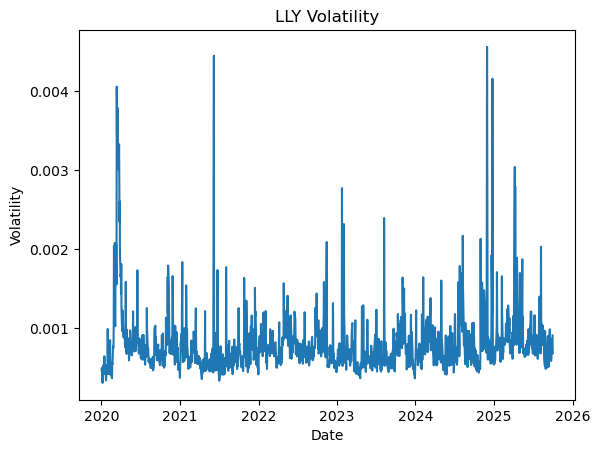

In [12]:
daily_volatility_LLY = np.sqrt(daily_variance_LLY)
plt.plot(daily_volatility_LLY.index, daily_volatility_LLY.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility")
plt.show()

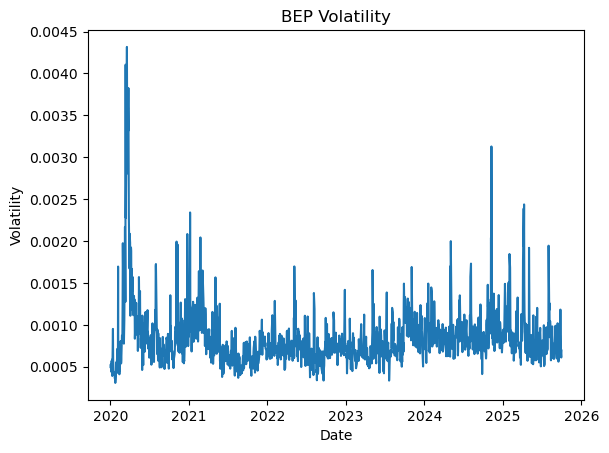

In [13]:
daily_volatility_BEP = np.sqrt(daily_variance_BEP)
plt.plot(daily_volatility_BEP.index, daily_volatility_BEP.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("BEP Volatility")
plt.show()

## Aggregated Volatility

Value ranges

In [30]:
def resample_data(df, frequency):
    agg_funcs = {'open': 'mean',
                 'close': 'mean',
                 'high': 'max',
                 'low': 'min',
                 'volume': 'sum'}
    
    df = df.set_index('timestamp')

    resampled_df = df.resample(frequency).agg(agg_funcs)
    
    resampled_df = resampled_df.reset_index()

    return resampled_df

def volatility_df(df, frequency):
    
    resampled_df = resample_data(df, frequency)

    resampled_df['open-close'] = resampled_df['open'] - resampled_df['close']
    resampled_df['high-low'] = resampled_df['high'] - resampled_df['low']
    
    return resampled_df

time_intervals = ['1H', '1D', 'W', '1M', 'Q', 'Y'] # day, month, week, month, quarter, year

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


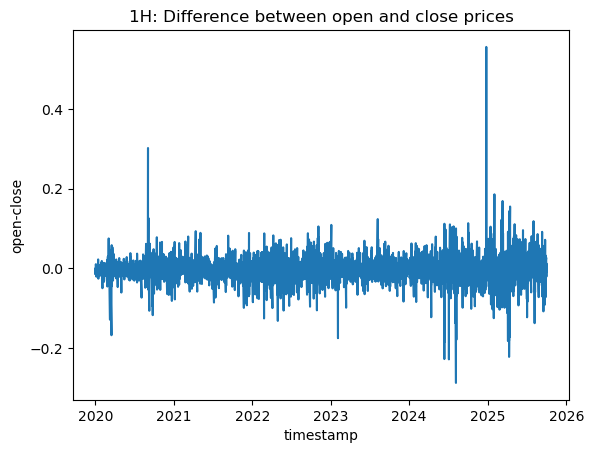

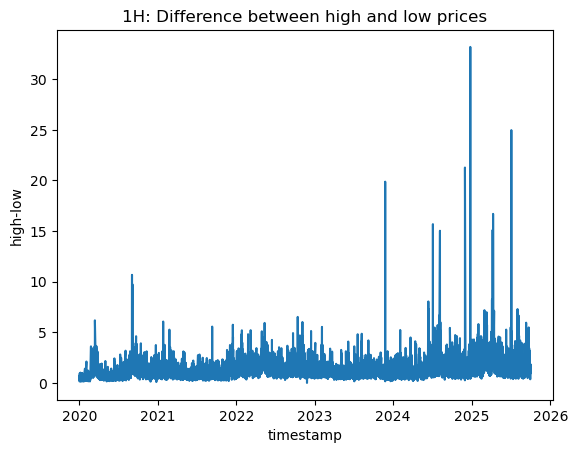

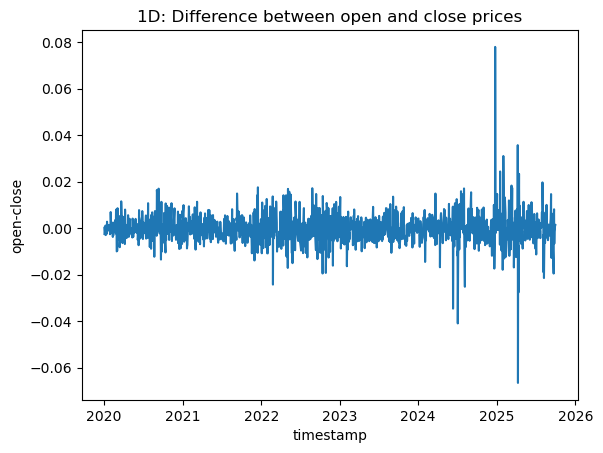

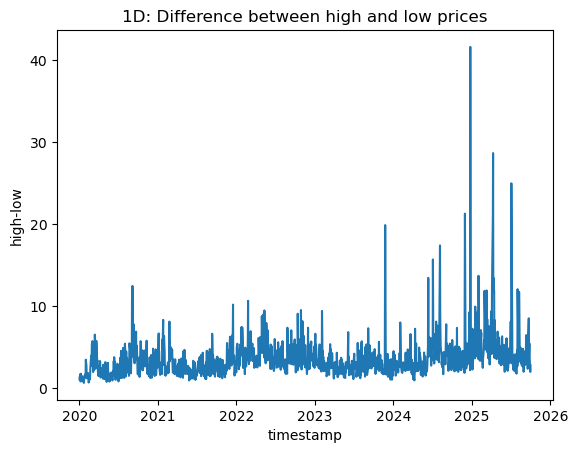

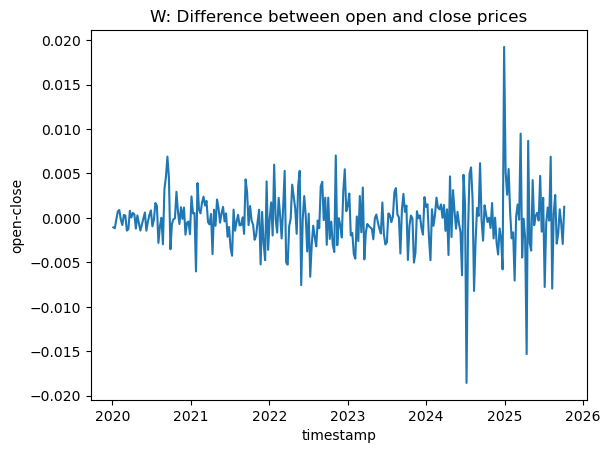

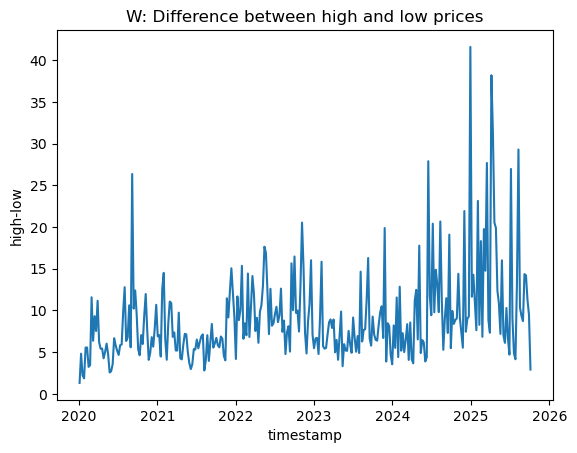

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


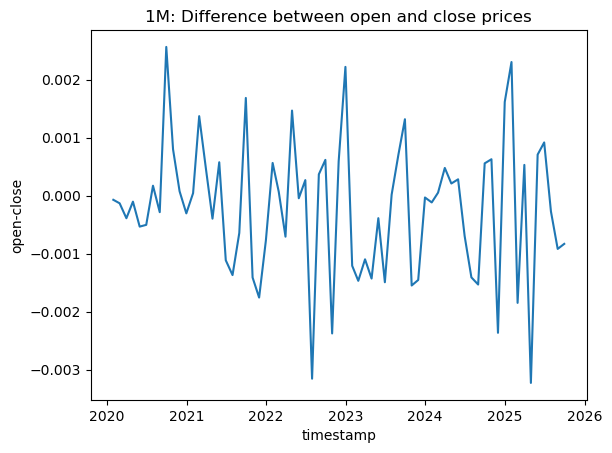

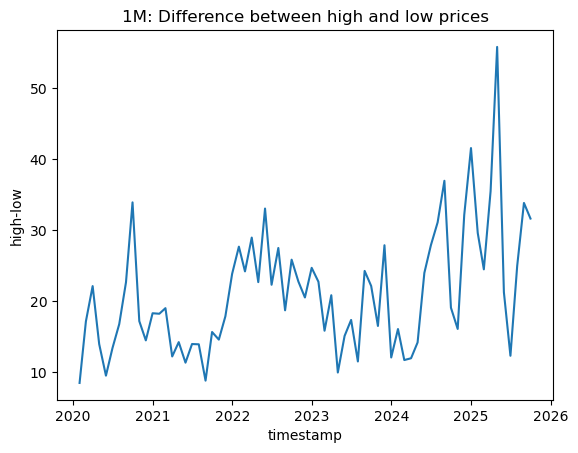

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


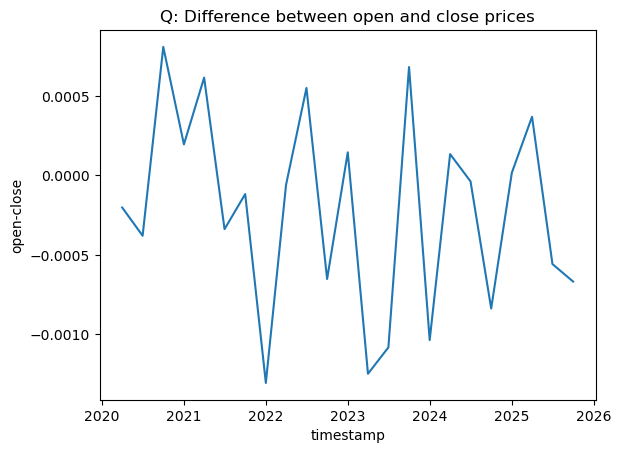

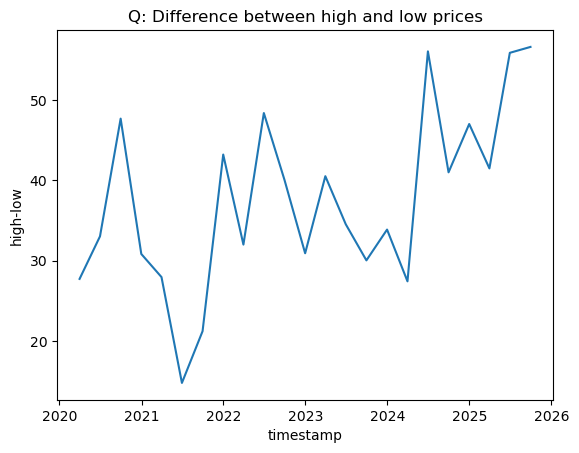

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


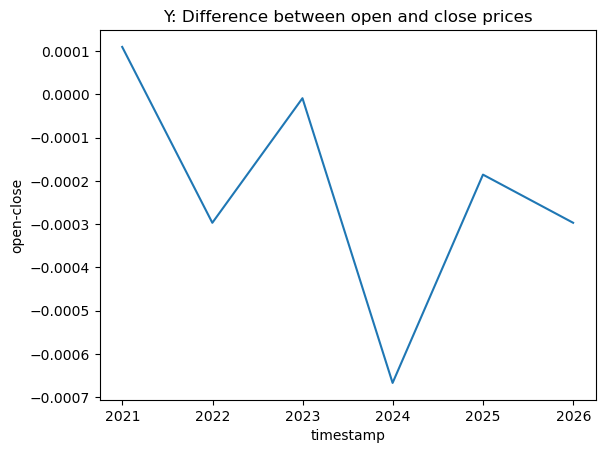

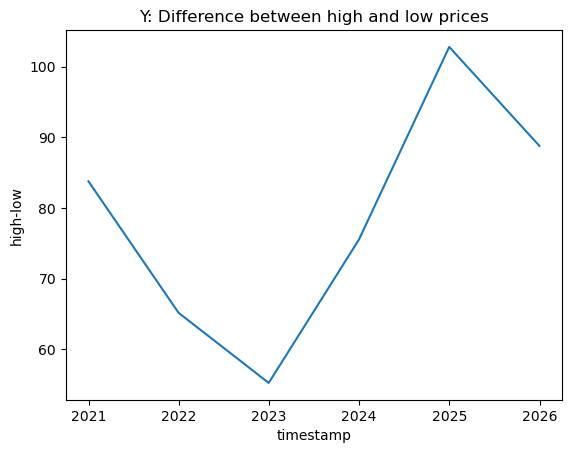

In [31]:
for inter in time_intervals:
    aapl_ranges = volatility_df(aapl_df, inter)

    plt.figure()
    sns.lineplot(data=aapl_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=aapl_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


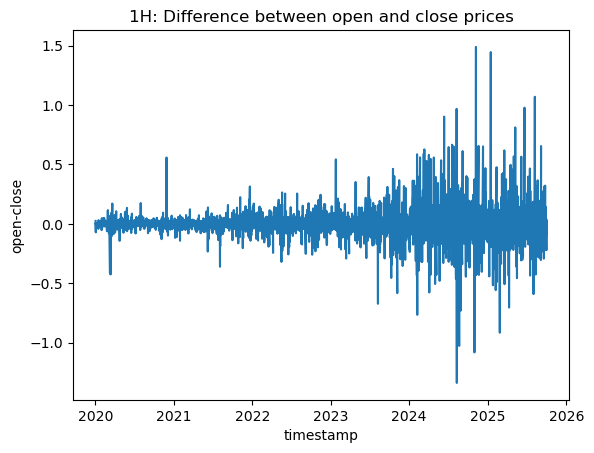

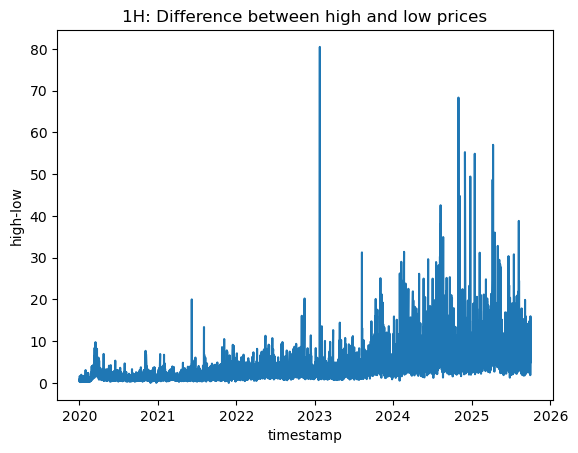

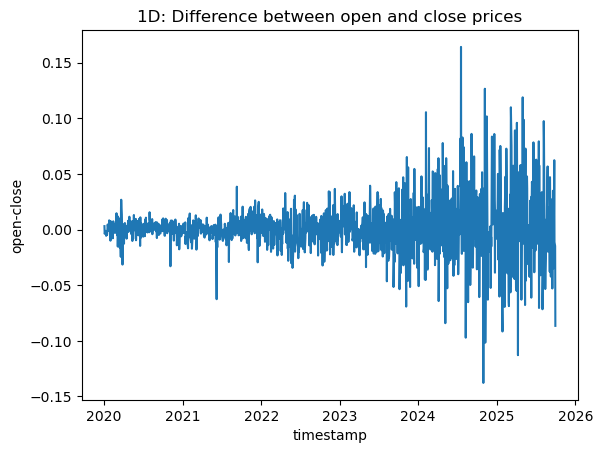

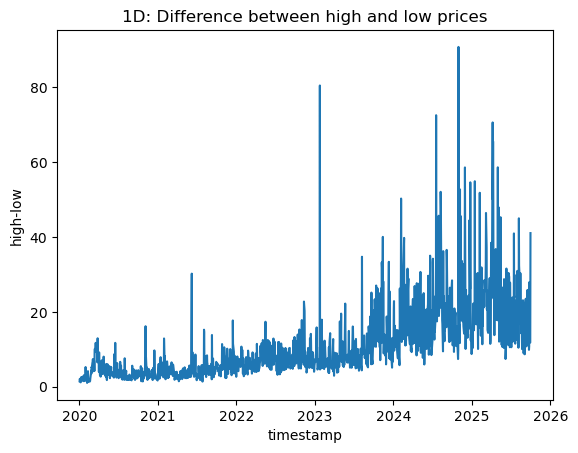

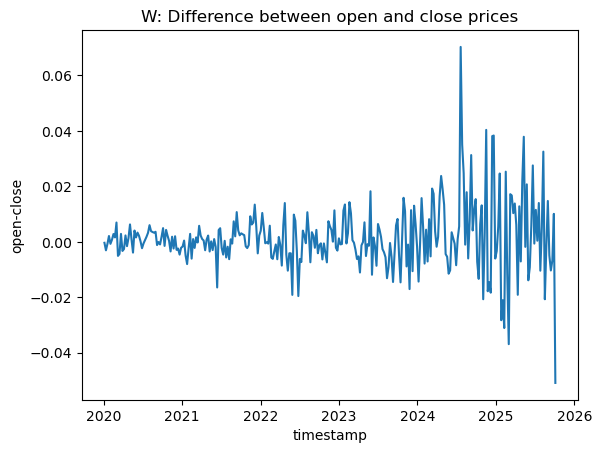

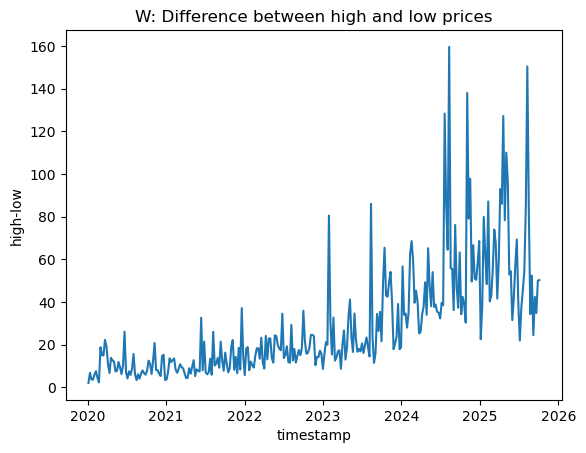

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


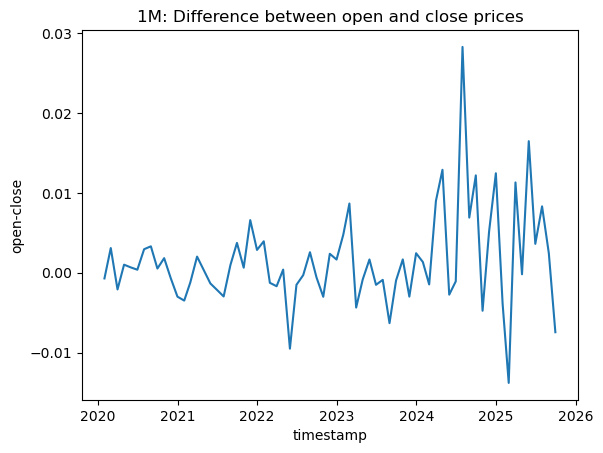

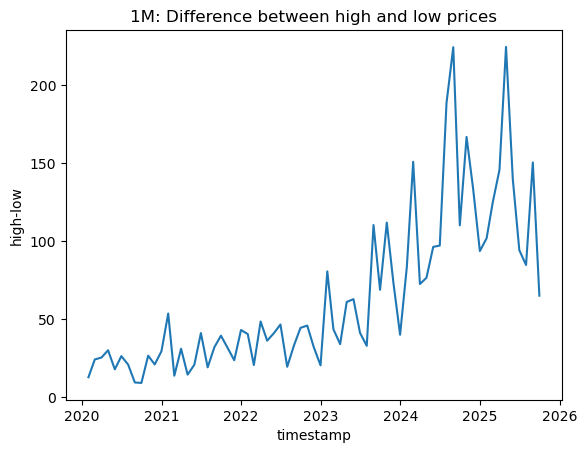

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


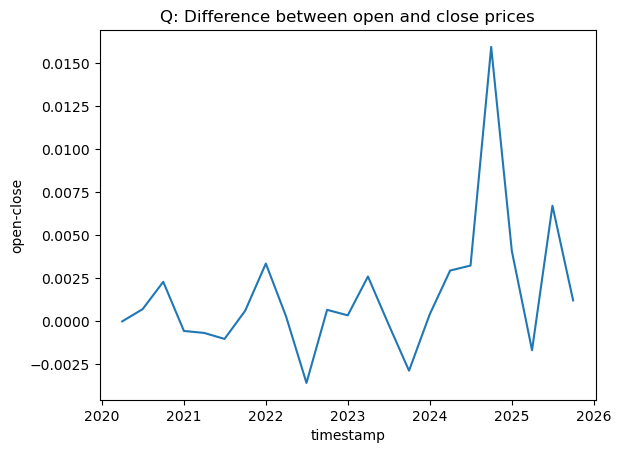

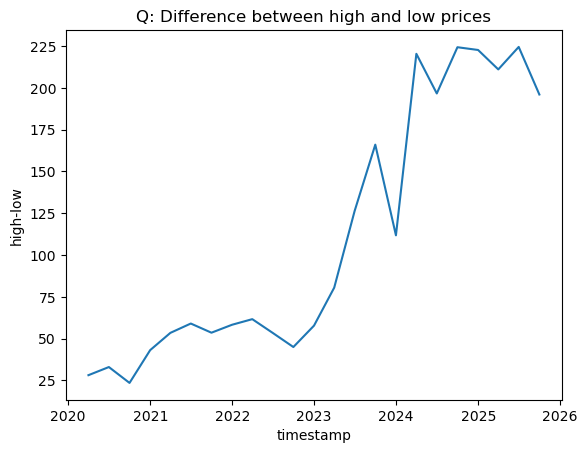

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


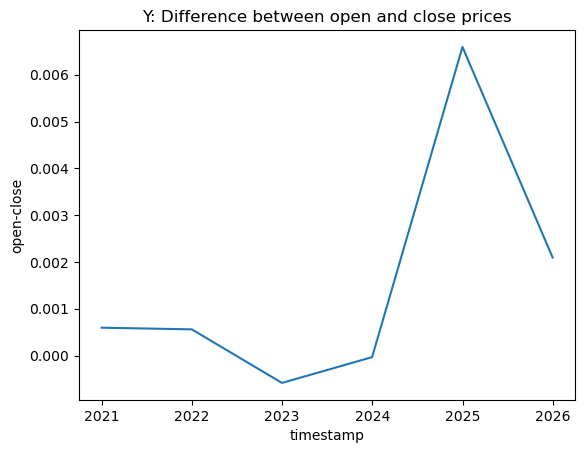

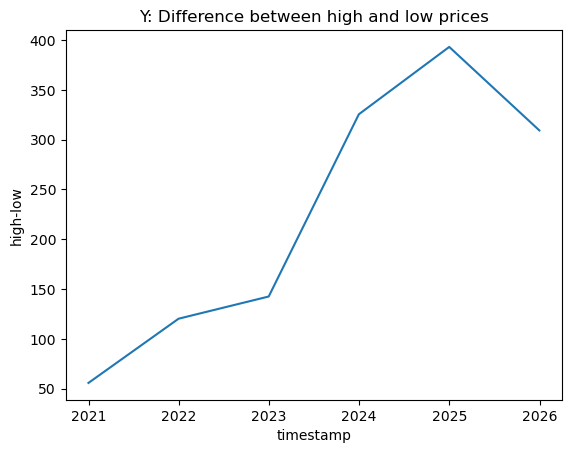

In [32]:
 for inter in time_intervals:
    lly_ranges = volatility_df(lly_df, inter)

    plt.figure()
    sns.lineplot(data=lly_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=lly_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


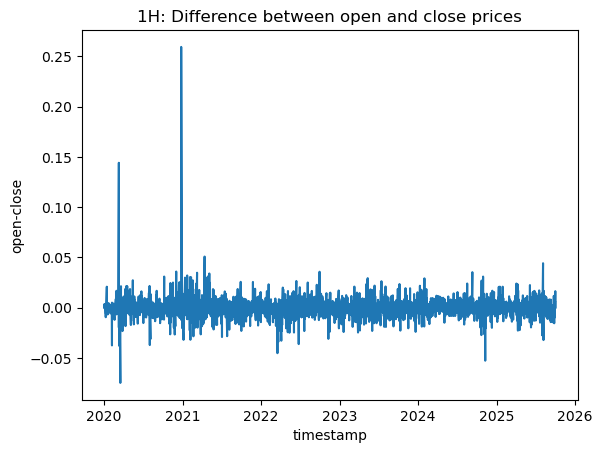

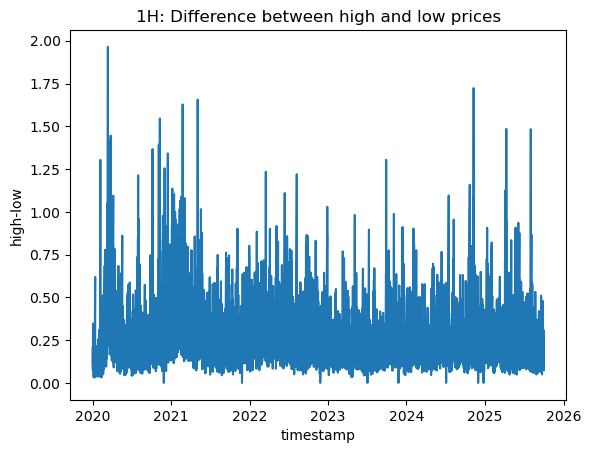

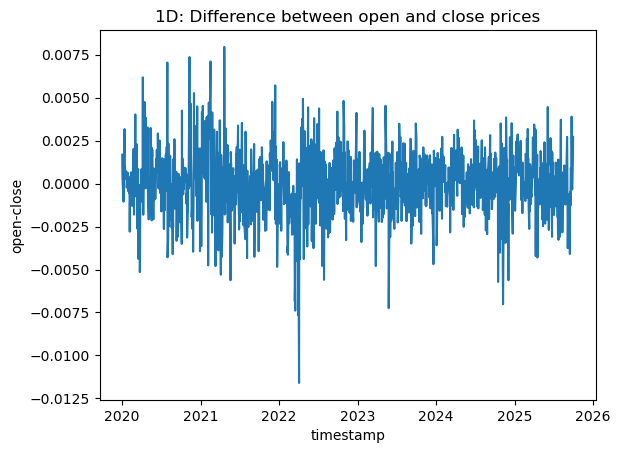

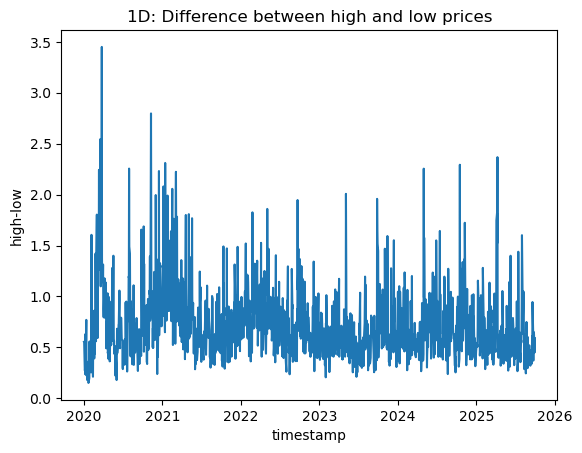

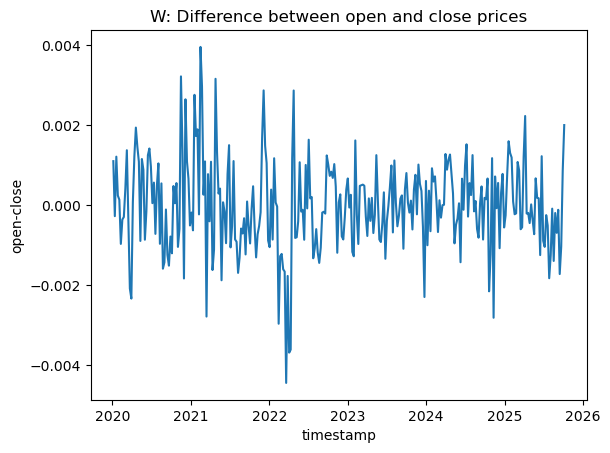

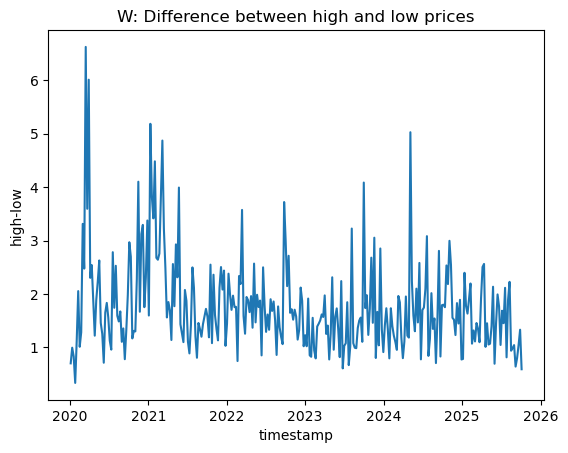

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


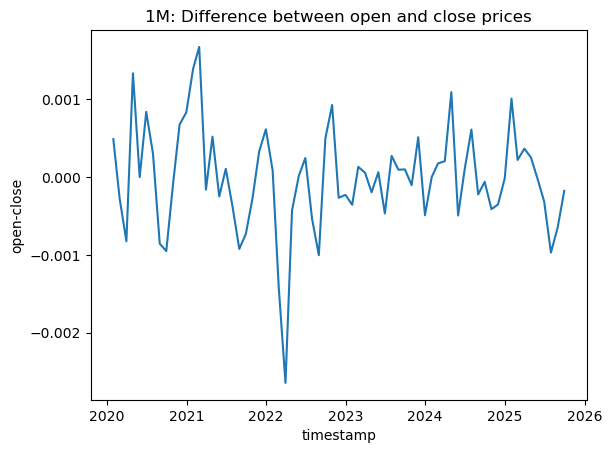

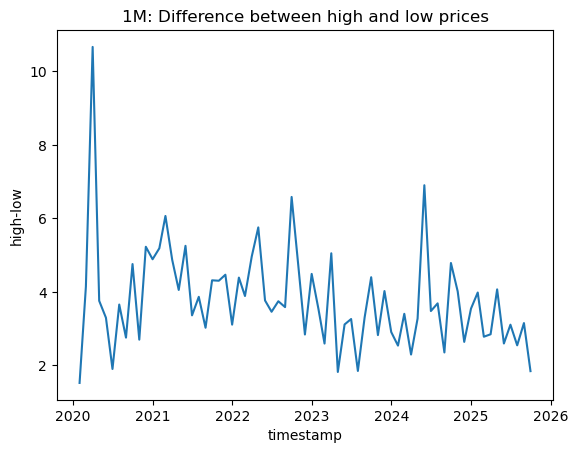

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


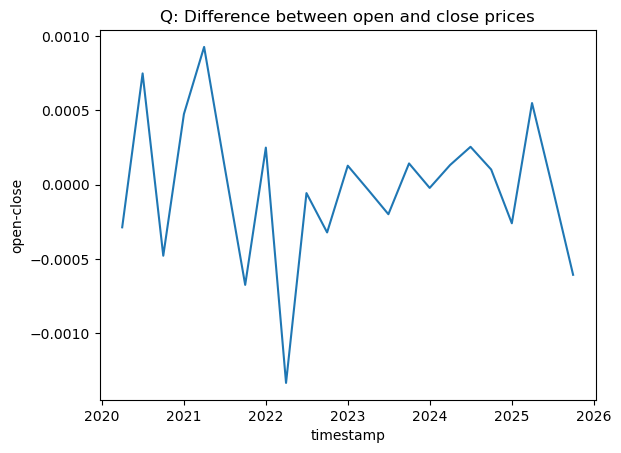

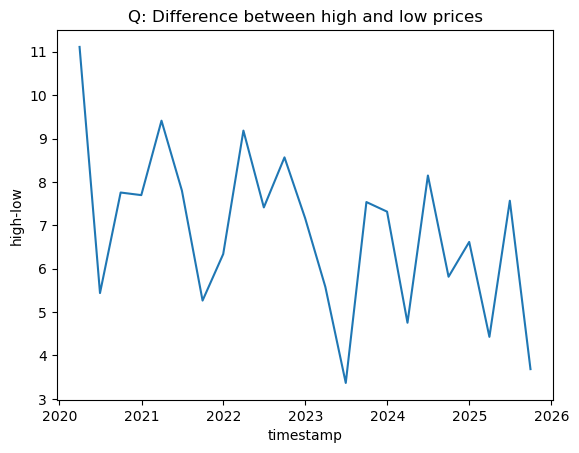

/var/folders/vb/pdc3w9394cvftrnpc2zrn3dc0000gn/T/ipykernel_71839/2937016153.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


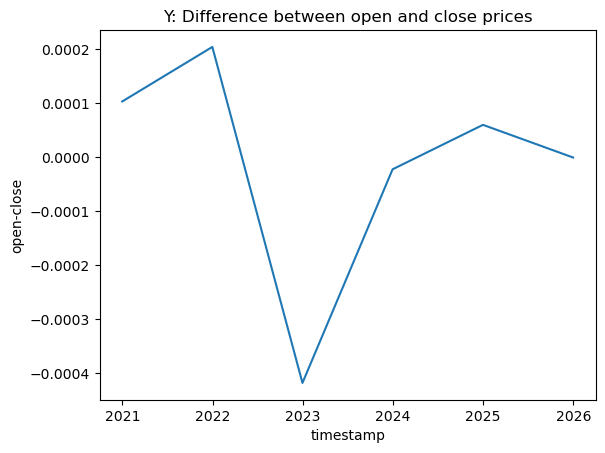

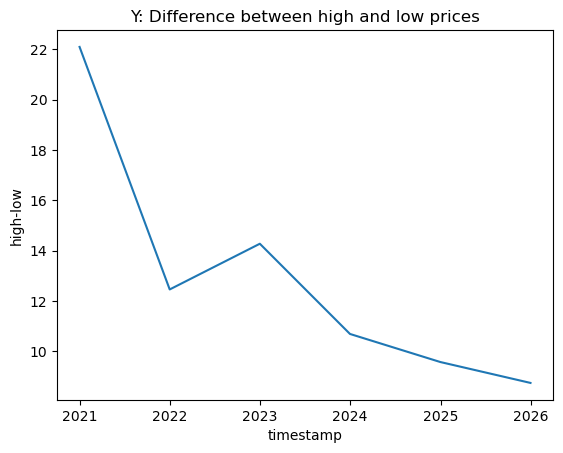

In [33]:
for inter in time_intervals:
    bep_ranges = volatility_df(bep_df, inter)

    plt.figure()
    sns.lineplot(data=bep_ranges, x='timestamp', y='open-close')
    plt.title(f'{inter}: Difference between open and close prices')
    plt.show()

    plt.figure()
    sns.lineplot(data=bep_ranges, x='timestamp', y='high-low')
    plt.title(f'{inter}: Difference between high and low prices')
    plt.show()

# Correlation

In [34]:
for lag in range(1,20):
    print(lag, pd.Series(daily_volatility_AAPL).autocorr(lag=lag))

1 0.5769805692458503
2 0.5453167336440363
3 0.4821113717639656
4 0.42744090257569606
5 0.3864652909470627
6 0.3525342140542362
7 0.34637349276087337
8 0.3158855263388463
9 0.3106950930319282
10 0.297291495594944
11 0.2688191606425518
12 0.23560465797148583
13 0.2358833454408587
14 0.21831307739680791
15 0.19106833843457732
16 0.19857795585558516
17 0.17201112496576124
18 0.16509769944055827
19 0.16609037639978244


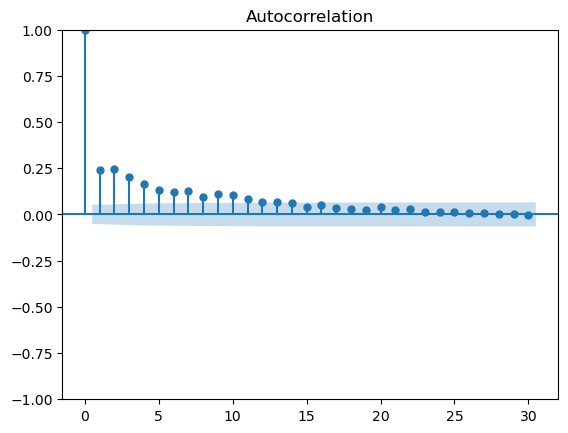

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_variance_AAPL, lags=30)

In [36]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_BEP).autocorr(lag=lag))

1 0.6837558923028522
2 0.6514615802746551
3 0.5983315496768644
4 0.5518487177894505
5 0.5174831319293282


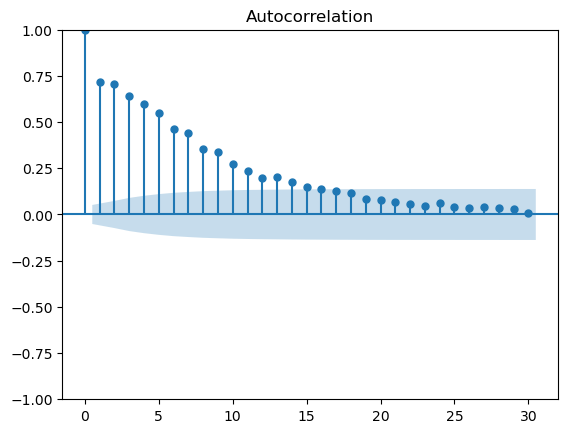

In [37]:
plot_acf(daily_variance_BEP, lags=30)

In [38]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_LLY).autocorr(lag=lag))

1 0.5470570909894626
2 0.48744389860830095
3 0.4214346943936259
4 0.3980873030426875
5 0.36517993620454686


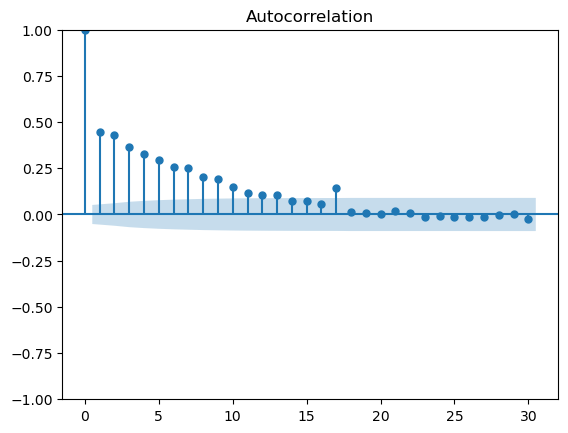

In [43]:
plot_acf(daily_variance_LLY, lags=30)
plt.show()

# EWMA

In [41]:
daily_volatility_AAPL

time_stamp
2020-01-02    0.000447
2020-01-03    0.000564
2020-01-06    0.000436
2020-01-07    0.000453
2020-01-08    0.000482
                ...   
2025-09-24    0.000509
2025-09-25    0.000627
2025-09-26    0.000486
2025-09-29    0.000423
2025-09-30    0.000454
Name: log_return, Length: 1444, dtype: float64

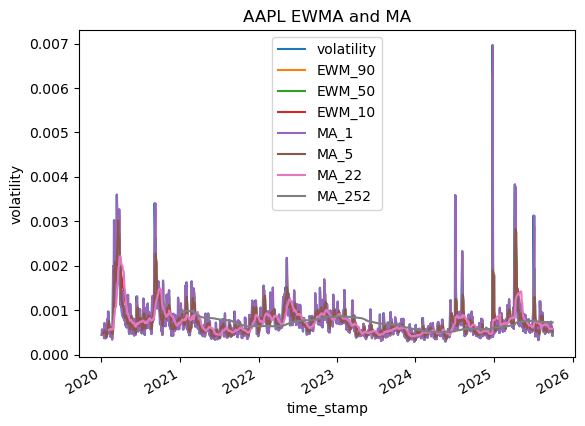

In [14]:
daily_volatility_AAPL.name = 'volatility'
daily_volatility_AAPL = daily_volatility_AAPL.to_frame()
daily_volatility_AAPL['EWM_90'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_AAPL['EWM_50'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_AAPL['EWM_10'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_AAPL['MA_1'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=1).mean()
daily_volatility_AAPL['MA_5'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=5).mean()
daily_volatility_AAPL['MA_22'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=22).mean()
daily_volatility_AAPL['MA_252'] = daily_volatility_AAPL['volatility'].shift(1).rolling(window=252).mean()
daily_volatility_AAPL.plot()
plt.title("AAPL EWMA and MA")
plt.ylabel("volatility")
plt.show()

In [15]:
moving_average_AAPL = {
    "MA_1": daily_volatility_AAPL['MA_1'],
    "MA_5": daily_volatility_AAPL['MA_5'],
    "MA_22": daily_volatility_AAPL['MA_22'],
    "MA_252": daily_volatility_AAPL['MA_252']
}

In [18]:
df = pd.DataFrame(moving_average_AAPL)
df.to_csv("AAPL_moving_average.csv.gz", compression="gzip")

In [30]:
# daily_volatility_BEP.name = 'volatility'
# daily_volatility_BEP = daily_volatility_BEP.to_frame()
# daily_volatility_BEP['EWM_90'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.90).mean()
# daily_volatility_BEP['EWM_50'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.50).mean()
# daily_volatility_BEP['EWM_10'] = daily_volatility_BEP['volatility'].shift(1).ewm(alpha=.10).mean()

moving_average = pd.DataFrame()
MA = ["1", "5", "22", "252"]
for window in MA:
    column_name = f"MA_{window}"
    moving_average[column_name] = daily_volatility_BEP['volatility'].shift(1).rolling(window=int(window)).mean()
    
# daily_volatility_BEP['MA_1'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=1).mean()
# daily_volatility_BEP['MA_5'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=5).mean()
# daily_volatility_BEP['MA_22'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=22).mean()
# daily_volatility_BEP['MA_252'] = daily_volatility_BEP['volatility'].shift(1).rolling(window=252).mean()
# daily_volatility_BEP.plot()
# plt.title("BEP EWMA and MA")
# plt.ylabel("volatility")
# plt.show()

In [31]:
moving_average

,MA_1,MA_5,MA_22,MA_252
time_stamp,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,0.000495,NaN,NaN,NaN
2020-01-06,0.000529,NaN,NaN,NaN
2020-01-07,0.000438,NaN,NaN,NaN
2020-01-08,0.000570,NaN,NaN,NaN
...,...,...,...,...
2025-09-24,0.000871,0.000719,0.000723,0.000900
2025-09-25,0.000626,0.000727,0.000719,0.000899
2025-09-26,0.001182,0.000810,0.000743,0.000901


In [20]:
BEP_moving_average = {
    "MA_1": daily_volatility_BEP['MA_1'],
    "MA_5": daily_volatility_BEP['MA_5'],
    "MA_22": daily_volatility_BEP['MA_22'],
    "MA_252": daily_volatility_BEP['MA_252']
}
df = pd.DataFrame(BEP_moving_average)
df.to_csv("BEP_moving_average.csv.gz", compression="gzip")

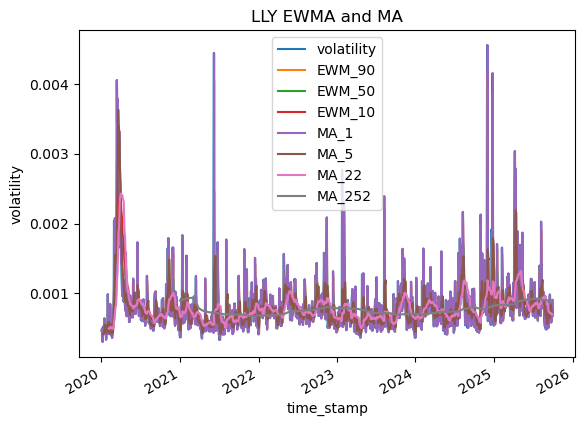

In [21]:
daily_volatility_LLY.name = 'volatility'
daily_volatility_LLY = daily_volatility_LLY.to_frame()
daily_volatility_LLY['EWM_90'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_LLY['EWM_50'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_LLY['EWM_10'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_LLY['MA_1'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=1).mean()
daily_volatility_LLY['MA_5'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=5).mean()
daily_volatility_LLY['MA_22'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=22).mean()
daily_volatility_LLY['MA_252'] = daily_volatility_LLY['volatility'].shift(1).rolling(window=252).mean()
daily_volatility_LLY.plot()
plt.title("LLY EWMA and MA")
plt.ylabel("volatility")
plt.show()

In [22]:
moving_average_LLY = {
    "MA_1": daily_volatility_LLY['MA_1'],
    "MA_5": daily_volatility_LLY['MA_5'],
    "MA_22": daily_volatility_LLY['MA_22'],
    "MA_252": daily_volatility_LLY['MA_252']
}
df = pd.DataFrame(moving_average_LLY)
df.to_csv("LLY_moving_average.csv.gz", compression="gzip")

In [ ]:
#EWMA formula, acts as basis to compare other models
def ewma_predict_Days(volatility, lambda_, days, loss):
    predicted = []
    true = []
    start = len(volatility) - days
    # print(start)
    for i in range(start, len(volatility)):
        historical = volatility.iloc[:i]
        # print("historical: ", historical)
        ewma_value = historical.ewm(alpha=lambda_).mean().iloc[-1]
        # print("ewma value: ", ewma_value)
        true.append(volatility.iloc[i])
        predicted.append(ewma_value)
    # print(true)
    # print(predicted)
    if loss == "MSE":
        return np.mean((np.array(true)-np.array(predicted))**2)
    else:
        return None

In [ ]:
#Use ewma and find the error in predicting the latest 20 days
mse_APPL = ewma_predict_Days(daily_volatility_AAPL, 0.94, 20, "MSE")
print("MSE: ", mse_APPL)

MSE:  1.0911267691521766e-08


In [ ]:
mse_LLY = ewma_predict_Days(daily_volatility_LLY, 0.94, 20, "MSE")
print("MSE LLY: ", mse_LLY)

MSE LLY:  2.23307755951079e-08


In [ ]:
mse_BEP = ewma_predict_Days(daily_volatility_BEP, 0.94, 20, "MSE")
print("BEP MSE: ", mse_BEP)

BEP MSE:  5.497451390562223e-08


# Outlier Detection

In [ ]:
df_AAPL = pd.read_csv("data_files/AAPL_combined.csv.gz")
AAPL_returns = pd.DataFrame({
    "time_stamp": df_AAPL["Unnamed: 0"],
    "log_return": np.log(1+(df_AAPL['4. close']-df_AAPL['1. open'])/df_AAPL['1. open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()


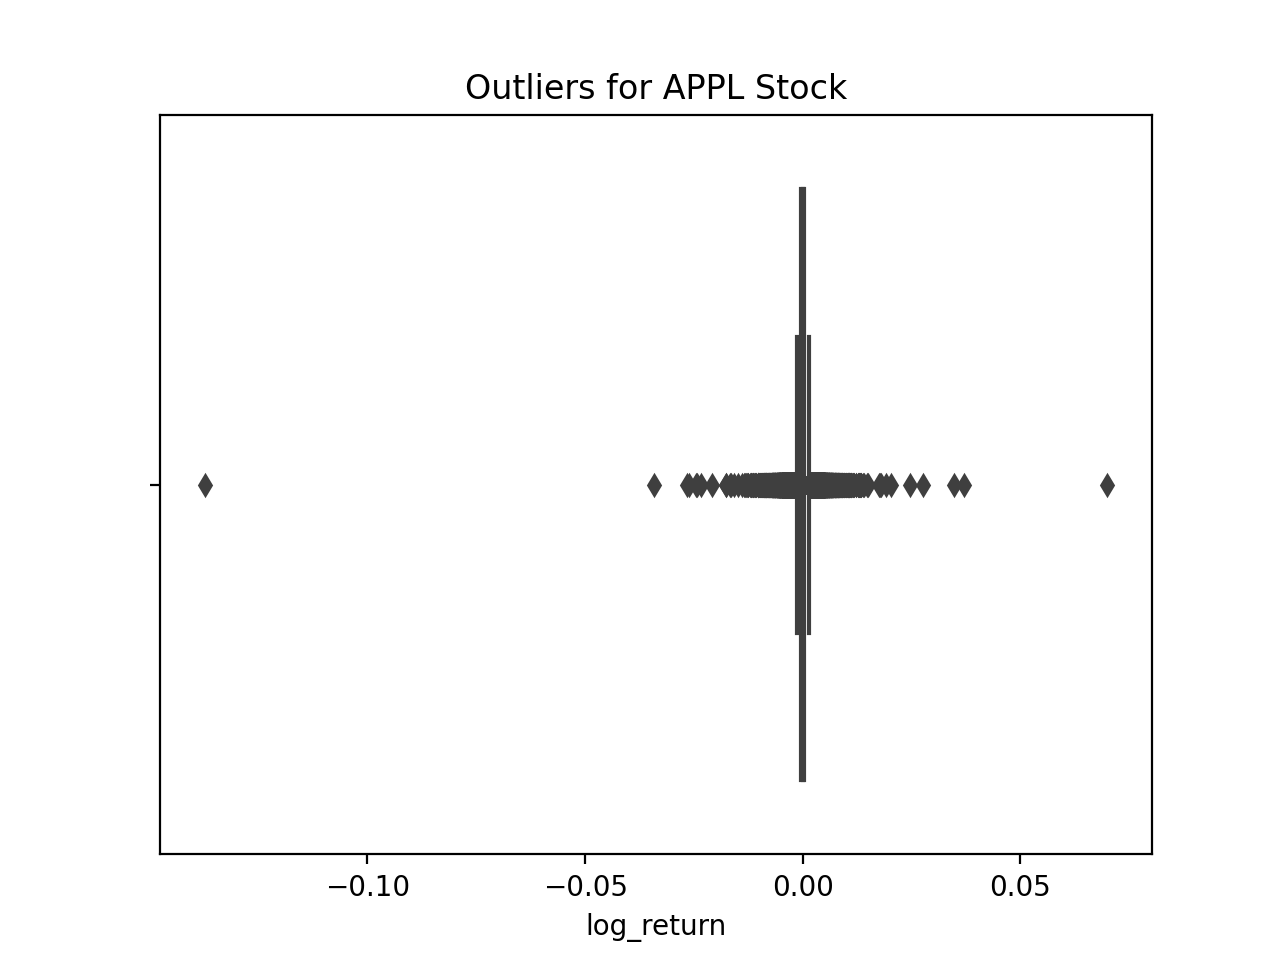

In [ ]:
sns.boxplot(x="log_return", data=AAPL_returns)
plt.title("Outliers for APPL Stock")
plt.show()

In [ ]:
lower_bound = AAPL_returns["log_return"].quantile(0.0125)
upper_bound = AAPL_returns["log_return"].quantile(0.9875)
AAPL_returns_filtered = AAPL_returns[(AAPL_returns["log_return"] >= lower_bound) & (AAPL_returns["log_return"] <= upper_bound)]
daily_variance_AAPL_filtered = AAPL_returns_filtered.groupby(AAPL_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
#Plot returns
AAPL_returns_filtered.set_index("time_stamp", inplace=True)
AAPL_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns Filtered")

Text(0.5, 1.0, 'Apple Returns Filtered')

In [ ]:
#Plot variance
plt.plot(daily_variance_AAPL_filtered.index, daily_variance_AAPL_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance Filtered")

Text(0.5, 1.0, 'Apple Variance Filtered')

In [ ]:
#Plot volatility
daily_volatility_AAPL_filtered = np.sqrt(daily_variance_AAPL_filtered)
plt.plot(daily_volatility_AAPL_filtered.index, daily_volatility_AAPL_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Apple Volatility Filtered")

Text(0.5, 1.0, 'Apple Volatility Filtered')

In [ ]:
#Use ewma and find the error in predicting the latest 20 days
mse_APPL = ewma_predict_Days(daily_volatility_AAPL_filtered, 0.94, 20, "MSE")
print("MSE: ", mse_APPL)

MSE:  7.772117950190128e-09


In [ ]:
df = pd.read_csv("data_files/BEP_combined.csv.gz")
df.columns
BEP_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
BEP_returns['time_stamp'] = pd.to_datetime(BEP_returns['time_stamp'], errors='coerce')
daily_variance_BEP = BEP_returns.groupby(BEP_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

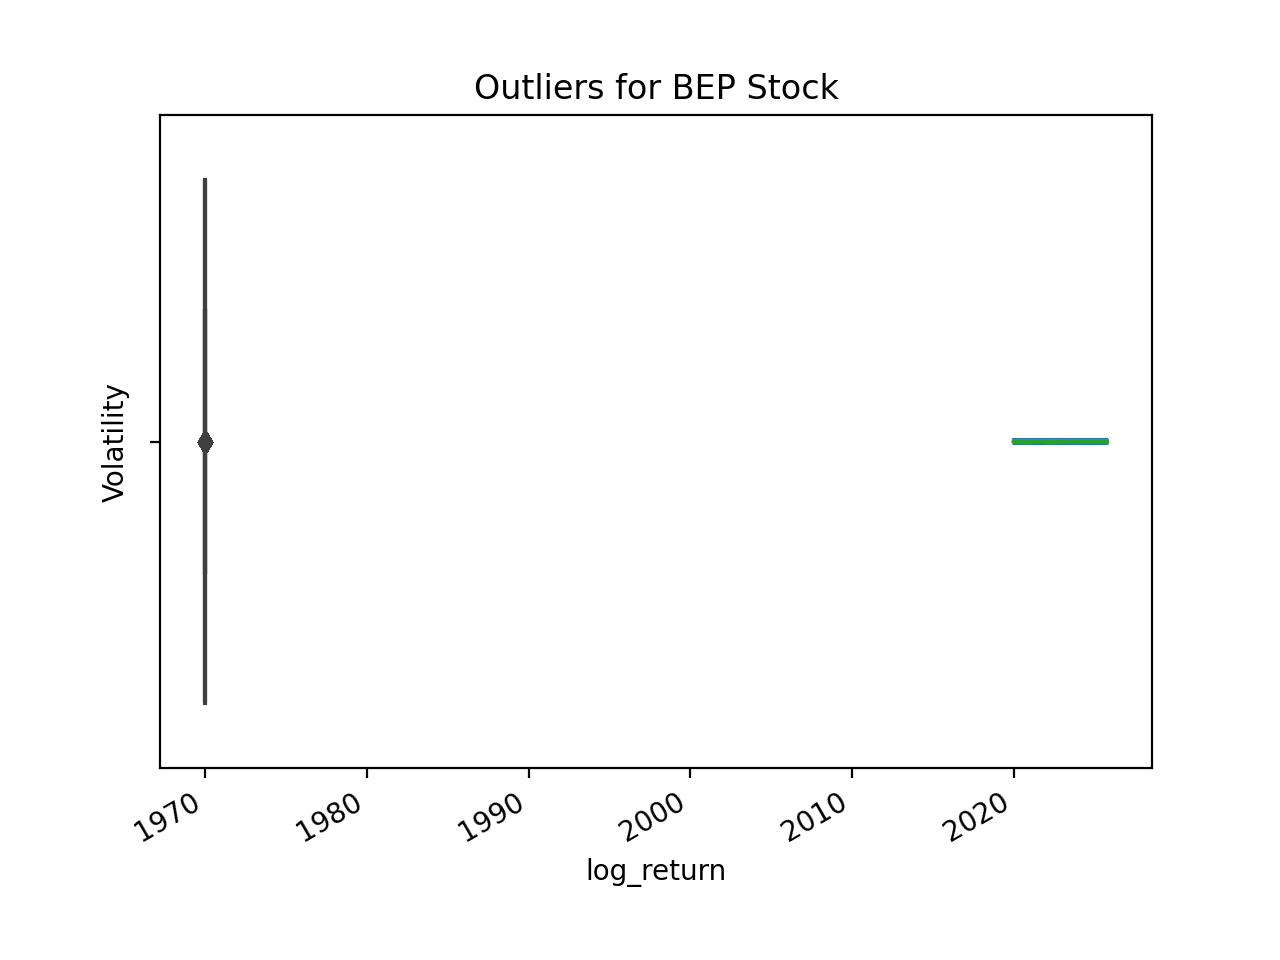

In [ ]:
sns.boxplot(x="log_return", data=BEP_returns)
plt.title("Outliers for BEP Stock")
plt.show()

In [ ]:
lower_bound = BEP_returns["log_return"].quantile(0.0125)
upper_bound = BEP_returns["log_return"].quantile(0.9875)
BEP_returns_filtered = BEP_returns[(BEP_returns["log_return"] >= lower_bound) & (BEP_returns["log_return"] <= upper_bound)]
daily_variance_BEP_filtered = BEP_returns_filtered.groupby(BEP_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
BEP_returns_filtered.set_index("time_stamp", inplace=True)
BEP_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("BEP Returns Filtered")

Text(0.5, 1.0, 'BEP Returns Filtered')

In [ ]:
plt.plot(daily_variance_BEP_filtered.index, daily_variance_BEP_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("BEP Variance Filtered")

Text(0.5, 1.0, 'BEP Variance Filtered')

In [ ]:
daily_volatility_BEP_filtered = np.sqrt(daily_variance_BEP_filtered)
plt.plot(daily_volatility_BEP_filtered.index, daily_volatility_BEP_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("BEP Volatility filtered")

Text(0.5, 1.0, 'BEP Volatility filtered')

In [ ]:
mse_BEP = ewma_predict_Days(daily_volatility_BEP_filtered, 0.94, 20, "MSE")
print("BEP Filtered MSE: ", mse_BEP)

BEP Filtered MSE:  1.361859327667227e-08


In [ ]:
df = pd.read_csv("data_files/LLY_combined.csv.gz")
df.columns
LLY_returns = pd.DataFrame({
    "time_stamp": df["Unnamed: 0"],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

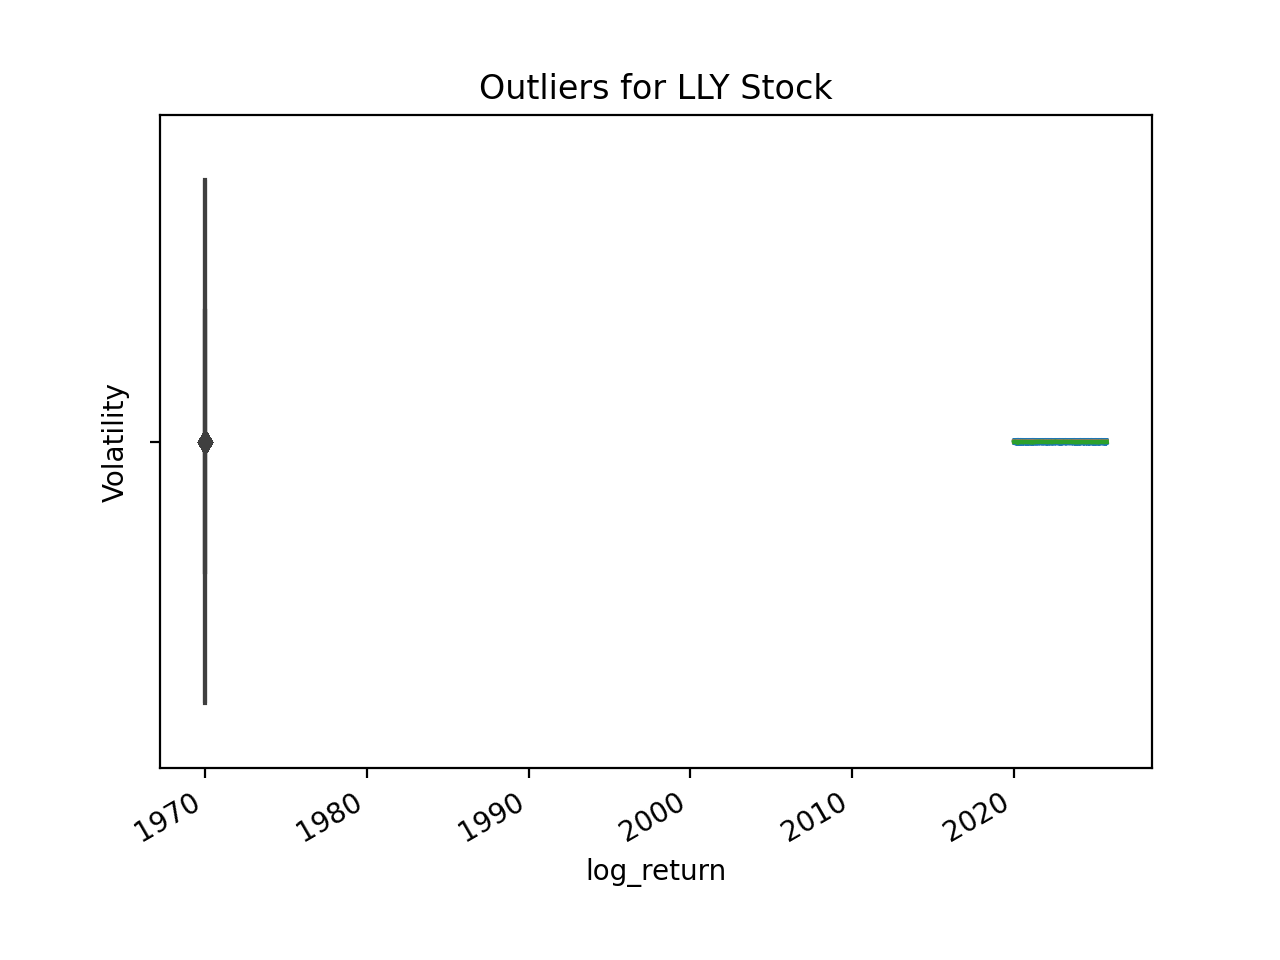

In [ ]:
sns.boxplot(x="log_return", data=LLY_returns)
plt.title("Outliers for LLY Stock")
plt.show()

In [ ]:
lower_bound = LLY_returns["log_return"].quantile(0.0125)
upper_bound = LLY_returns["log_return"].quantile(0.9875)
LLY_returns_filtered = LLY_returns[(LLY_returns["log_return"] >= lower_bound) & (LLY_returns["log_return"] <= upper_bound)]
daily_variance_LLY_filtered = LLY_returns_filtered.groupby(LLY_returns_filtered['time_stamp'].dt.floor("1D"))["log_return"].var()

In [ ]:
LLY_returns_filtered.set_index("time_stamp", inplace=True)
LLY_returns_filtered.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns Filtered")

Text(0.5, 1.0, 'LLY Returns Filtered')

In [ ]:
plt.plot(daily_variance_LLY_filtered.index, daily_variance_LLY_filtered.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance Filtered")

Text(0.5, 1.0, 'LLY Variance Filtered')

In [ ]:
daily_volatility_LLY_filtered = np.sqrt(daily_variance_LLY_filtered)
plt.plot(daily_volatility_LLY_filtered.index, daily_volatility_LLY_filtered.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility Filtered")

Text(0.5, 1.0, 'LLY Volatility Filtered')

In [ ]:
mse_LLY = ewma_predict_Days(daily_volatility_LLY_filtered, 0.94, 20, "MSE")
print("MSE Filtered LLY: ", mse_LLY)

MSE Filtered LLY:  8.297770244358856e-09


# Next Steps

Next Steps:
Want to incorporate secondary data to better predict volatility.
We plan to base our approach off of Trading Volume Alpha paper.
Model will consist of 4 kinds of features

Lagged moving averages of returns (as we did originally using EWMA),
fundamental characteristics of each stock: market equity, standardized earnings surprise, book leverage, book-to-market equity, Dimson beta, and firm age, calendar Dates that effect trading volume: Early closing, triple witching days, double witching days, Russell index re-balancing, earnings release schedule (using one hot encoding) for if a stock has an upcoming earnings release or has just had one

We will use a simple neural network model with three fully connected hidden layers of 32, 16, and 8 ReLU nodes and one linear output node.

We will evaluate the model using MSE and compare its performance with the EWMA.


References:
Goyenko, Ruslan and Kelly, Bryan T. and Moskowitz, Tobias J. and Moskowitz, Tobias J. and Su, Yinan and Zhang, Chao, Trading Volume Alpha (May 15, 2024). Available at SSRN: https://ssrn.com/abstract=4802345 or http://dx.doi.org/10.2139/ssrn.4802345
https://saltfinancial.com/static/uploads/2021/05/The%20Laymans%20Guide%20to%20Volatility%20Forecasting.pdf